## **Introduction**

This notebook investigates **claim-level** veracity prediction on the **X-FACT** dataset as part of a broader study on misinformation detection across multilingual benchmarks. The focus is on evaluating how different modeling approaches perform under both **monolingual** conditions (training and testing within English, Spanish, and Polish) and **cross-lingual transfer** settings (training on English and testing on Spanish and Polish). The workflow includes dataset cleaning, majority-vote label consolidation, decontamination of splits, language and class distribution analysis and a systematic comparison of three baselines: TF–IDF + Complement Naive Bayes, FastText embeddings with a multilayer perceptron, and a fine-tuned XLM-RoBERTa classifier.


In [ ]:
!pip install -q datasets
!pip install -q transformers
!pip install -q gensim
!pip install -q evaluate

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset, Dataset as HfDataset
import gensim
from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, average_precision_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt
import evaluate
import random
from pprint import pprint
import os
import nltk
import gensim.downloader as api

pd.set_option('future.no_silent_downcasting', True)

nltk.download("punkt")
nltk.download("punkt_tab")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_dir = "/content/drive/MyDrive/misinfo_project"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

## **Dataset and Pre-processing**

The **X-Fact** subset of the ComplexDataLab Misinfo_Datasets is used, which contains multilingual fact-checking claims annotated as *false*, *true*, or *unknown*. Each example includes a claim text, 5 evidence, language, and multiple additional metadata fields.

The preprocessing pipeline consists of:
- Keeping only the `claim`, `veracity`, and `language` columns.
- Replacing literal `"na"` strings with missing values and dropping empty rows.
- Collapsing multiple annotations per claim using a majority vote (threshold 0.7).
- Removing any claims that appear across train/validation/test splits to avoid leakage.

After preprocessing, the final dataset contains **25,880** training examples, **3,682** validation examples, and **7,381** test examples, with no overlapping claims between splits.


In [ ]:
SUBSET_NAME = "x_fact"
TEXT_COL = "claim"
LABEL_COL = "veracity"
LANGUAGE_COL = "language"

In [ ]:
ds = load_dataset("ComplexDataLab/Misinfo_Datasets", SUBSET_NAME)
ds

In [ ]:
def hf_clean(ds_split, text_col=TEXT_COL, label_col=LABEL_COL, language_col=LANGUAGE_COL):
    df = ds_split.to_pandas()

    df = df.replace("na", np.nan)

    df = df[[text_col, label_col, language_col]].dropna()
    df[text_col]  = df[text_col].astype(str).str.strip()
    df[label_col] = df[label_col].astype(str).str.strip()
    df = df[(df[text_col] != "") & (df[label_col] != "")]

    return df

In [ ]:
def collapse_by_majority_label(df, text_col=TEXT_COL, label_col=LABEL_COL, language_col=LANGUAGE_COL, min_majority=0.7):
    # count labels per claim
    label_counts = (
        df.groupby([text_col, label_col])
          .size()
          .rename("count")
          .reset_index()
    )

    # for each claim, find majority label and its proportion
    total_per_claim = label_counts.groupby(text_col)["count"].transform("sum")
    label_counts["prop"] = label_counts["count"] / total_per_claim

    majority = (label_counts.sort_values("prop", ascending=False)
                           .drop_duplicates(subset=[text_col]))

    # keep only claims where majority label has enough support
    majority = majority[majority["prop"] >= min_majority]

    clean_df = majority[[text_col, label_col]].copy()
    languages = df[[text_col, language_col]].drop_duplicates(subset=[text_col])
    clean_df = clean_df.merge(languages, on=text_col, how="left")

    return clean_df

In [ ]:
clean_train_df = hf_clean(ds["train"])
clean_val_df = hf_clean(ds["validation"])
clean_test_df = hf_clean(ds["test"])

In [ ]:
train_df = collapse_by_majority_label(clean_train_df)
val_df = collapse_by_majority_label(clean_val_df)
test_df = collapse_by_majority_label(clean_test_df)

In [ ]:
print("Original train size:", len(clean_train_df))
print("After collapsing, train size:", len(train_df))
print("Original val size  :", len(clean_val_df))
print("After collapsing, val size  :", len(val_df))
print("Original test size :", len(clean_test_df))
print("After collapsing, test size :", len(test_df))

Original train size: 25923
After collapsing, train size: 25880
Original val size  : 3695
After collapsing, val size  : 3695
Original test size : 7413
After collapsing, test size : 7405


In [ ]:
train_claims = set(train_df[TEXT_COL])
val_claims   = set(val_df[TEXT_COL])
test_claims  = set(test_df[TEXT_COL])

# Pairwise overlaps
train_val_overlap  = train_claims & val_claims
train_test_overlap = train_claims & test_claims
val_test_overlap   = val_claims & test_claims

# Triple overlap (in all three splits)
all_three_overlap = train_claims & val_claims & test_claims

print("Unique claims per split:")
print(f"  Train: {len(train_claims)}")
print(f"  Val  : {len(val_claims)}")
print(f"  Test : {len(test_claims)}\n")

print("Overlapping claims:")
print(f"  Train ∩ Val      : {len(train_val_overlap)}")
print(f"  Train ∩ Test     : {len(train_test_overlap)}")
print(f"  Val ∩ Test       : {len(val_test_overlap)}")
print(f"  Train ∩ Val ∩ Test: {len(all_three_overlap)}")


Unique claims per split:
  Train: 25880
  Val  : 3695
  Test : 7405

Overlapping claims:
  Train ∩ Val      : 13
  Train ∩ Test     : 21
  Val ∩ Test       : 3
  Train ∩ Val ∩ Test: 0


In [ ]:
def remove_split_duplicates(train_df, val_df, test_df, text_col=TEXT_COL):
    """
    Remove examples from val and test sets that appear in train set
    """
    # Get unique claims from train set
    train_claims = set(train_df[text_col])

    # Remove duplicates from validation set
    val_df_clean = val_df[~val_df[text_col].isin(train_claims)].copy()

    # Remove duplicates from test set
    test_df_clean = test_df[~test_df[text_col].isin(train_claims)].copy()

    # Also remove any overlap between val and test
    val_claims_clean = set(val_df_clean[text_col])
    test_df_clean = test_df_clean[~test_df_clean[text_col].isin(val_claims_clean)]

    print(f"Removed {len(val_df) - len(val_df_clean)} duplicates from validation set")
    print(f"Removed {len(test_df) - len(test_df_clean)} duplicates from test set")
    print(f"Final sizes - Train: {len(train_df)}, Val: {len(val_df_clean)}, Test: {len(test_df_clean)}")

    return val_df_clean, test_df_clean

In [ ]:
val_df, test_df = remove_split_duplicates(train_df, val_df, test_df)

print("\nAfter deduplication:")
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Removed 13 duplicates from validation set
Removed 24 duplicates from test set
Final sizes - Train: 25880, Val: 3682, Test: 7381

After deduplication:
Train: 25880, Val: 3682, Test: 7381


### **Class and language distribution analysis**

The global **label distribution** is highly imbalanced:

- **false ≈ 60%**
- **true ≈ 31%**
- **unknown ≈ 8–9%**

The `unknown` class is both **rare** and often noisier (ambiguous or weakly supported claims).  
This makes `unknown` systematically harder to learn and tends to drag down **macro-F1**.

The **language distribution** is also skewed:

- English (`en`) and Portuguese (`pt`) dominate,
- while other languages (e.g., Spanish `es`, Polish `pl`, German `de`, Romanian `ro`, Serbian `sr`) have **much fewer examples**.

Label distributions per language show additional difficulties:
- some languages have **almost no `unknown` labels** (`hi`, `id`, `it`, `sr`, `ta`, `tr`),
- class ratios differ widely (e.g., `ar` is almost all `false`, `pl` has more `true` than `false`).

This combination of **class imbalance** and **language imbalance** explains why:
- macro-F1 is a more informative metric than accuracy,
- performance can vary a lot across languages, especially for `unknown`.


In [ ]:
def label_stats(df, split_name):
    print(f"\n=== {split_name}: Label distribution ===")
    counts = df[LABEL_COL].value_counts()
    perc = (counts / len(df) * 100).round(2)
    out = pd.DataFrame({"count": counts, "percent": perc})
    print(out)
    return out

lab_train = label_stats(train_df, "Train")
lab_val   = label_stats(val_df, "Validation")
lab_test  = label_stats(test_df, "Test")


=== Train: Label distribution ===
          count  percent
veracity                
false     15690    60.63
true       8000    30.91
unknown    2190     8.46

=== Validation: Label distribution ===
          count  percent
veracity                
false      2256    61.27
true       1140    30.96
unknown     286     7.77

=== Test: Label distribution ===
          count  percent
veracity                
false      4501    60.98
true       2249    30.47
unknown     631     8.55


In [ ]:
# Verify no overlaps remain
train_claims_final = set(train_df[TEXT_COL])
val_claims_final = set(val_df[TEXT_COL])
test_claims_final = set(test_df[TEXT_COL])

print(f"Train ∩ Val: {len(train_claims_final & val_claims_final)}")
print(f"Train ∩ Test: {len(train_claims_final & test_claims_final)}")
print(f"Val ∩ Test: {len(val_claims_final & test_claims_final)}")

Train ∩ Val: 0
Train ∩ Test: 0
Val ∩ Test: 0


In [ ]:
# unique labels from train
unique_labels = sorted(train_df[LABEL_COL].unique())
label2id = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

print("Label mapping:")
print(label2id)

Label mapping:
{'false': 0, 'true': 1, 'unknown': 2}


In [ ]:
# Add numeric labels
train_df["labels"] = train_df[LABEL_COL].map(label2id)
val_df["labels"] = val_df[LABEL_COL].map(label2id)
test_df["labels"] = test_df[LABEL_COL].map(label2id)

In [ ]:
train_df.head()

,claim,veracity,language,labels
0,👆this little beautiful girl was seen in mangal...,false,ta,0
1,""" 'denali' is the kenyan word for 'black power...",false,en,0
2,""" 'scary' fact about our national debt. in 179...",unknown,en,2
3,""" ... following world war ii war crime trials ...",true,en,1
4,""" … if the agreement goes into effect, the mil...",false,en,0


In [ ]:
def language_stats(df, split_name):
    print(f"\n=== {split_name}: Language distribution ===")
    counts = df[LANGUAGE_COL].value_counts()
    perc = (counts / len(df) * 100).round(2)
    out = pd.DataFrame({"count": counts, "percent": perc})
    print(out)
    return out

def label_by_language(df, split_name):
    print(f"\n=== {split_name}: Label distribution per language ===")
    table = (
        df.groupby(LANGUAGE_COL)[LABEL_COL]
          .value_counts(normalize=False)
          .unstack(fill_value=0)
          .sort_index()
    )
    table_perc = (table.div(table.sum(axis=1), axis=0) * 100).round(2)

    print("\nCounts:")
    print(table)

    print("\nRow-wise percentages:")
    print(table_perc)

    return table, table_perc

In [ ]:
lang_train = language_stats(train_df, "Train")
lang_val = language_stats(val_df, "Validation")
lang_test = language_stats(test_df, "Test")


=== Train: Language distribution ===
          count  percent
language                
en         8487    32.79
pt         5250    20.29
id         1859     7.18
ka         1419     5.48
ar         1414     5.46
pl         1216     4.70
ta         1032     3.99
it          876     3.38
es          868     3.35
tr          790     3.05
hi          781     3.02
de          655     2.53
ro          647     2.50
sr          586     2.26

=== Validation: Language distribution ===
          count  percent
language                
en         1237    33.60
pt          708    19.23
id          271     7.36
ka          204     5.54
ar          197     5.35
pl          173     4.70
ta          148     4.02
it          123     3.34
es          121     3.29
tr          117     3.18
de          105     2.85
hi           97     2.63
ro           96     2.61
sr           85     2.31

=== Test: Language distribution ===
          count  percent
language                
en         2372    32.14
pt     

In [ ]:
lab_lang_train, lab_lang_train_perc = label_by_language(train_df, "Train")
lab_lang_val, lab_lang_val_perc = label_by_language(val_df, "Validation")
lab_lang_test, lab_lang_test_perc = label_by_language(test_df, "Test")


=== Train: Label distribution per language ===

Counts:
veracity  false  true  unknown
language                      
ar         1352    41       21
de          581    74        0
en         3975  2853     1659
es          379   399       90
hi          781     0        0
id         1730   129        0
it          463   413        0
ka          593   699      127
pl          448   707       61
pt         3296  1738      216
ro          435   196       16
sr          500    86        0
ta          760   272        0
tr          397   393        0

Row-wise percentages:
veracity   false   true  unknown
language                        
ar         95.62   2.90     1.49
de         88.70  11.30     0.00
en         46.84  33.62    19.55
es         43.66  45.97    10.37
hi        100.00   0.00     0.00
id         93.06   6.94     0.00
it         52.85  47.15     0.00
ka         41.79  49.26     8.95
pl         36.84  58.14     5.02
pt         62.78  33.10     4.11
ro         67.23  30.29     

## **Evaluation Utilities**

- **Confusion matrices** (raw counts + normalized):
  - Show which pairs of labels (`false`, `true`, `unknown`) are most frequently confused.
- **Macro-F1**:
  - Averages F1 across classes and is robust to class imbalance.
- **Macro and Micro AUPRC**:
  - Evaluate how well the model’s **probability scores** rank the true labels.
- **Expected Calibration Error (ECE)**:
  - Measures how well predicted probabilities reflect actual accuracy (e.g., “are 0.8-confidence predictions correct ~80% of the time?”).
- **Error tables**:
  - For each misclassified example, store:
    - the original text,
    - ground-truth label,
    - predicted label,
    - model confidence and per-class probabilities.

These utilities are shared by all models (Complement Naive Bayes, FastText+MLP, XLM-R) so their performance and typical errors can be directly compared.


In [ ]:
def plot_confusion(y_true, probs, id2label=id2label, normalize=False, title=None):
    """
    y_true: ground truth labels (numpy array)
    probs: predicted probabilities from model (numpy array)
    normalize: True → show percentages, False → raw counts
    """
    preds = probs.argmax(axis=1)

    cm = confusion_matrix(y_true, preds, normalize='true' if normalize else None)

    labels = [id2label[i] for i in sorted(id2label.keys())]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    if title:
        plt.title(title)
    plt.show()

    return cm

In [ ]:
CLASS_IDS = sorted(id2label.keys())

def compute_auprc(probs, y_true, class_ids=CLASS_IDS):
    """
    probs: [N, num_classes]
    y_true: [N] (int labels)
    """
    y_bin = label_binarize(y_true, classes=class_ids)  # [N, C]
    auprc_macro = average_precision_score(y_bin, probs, average="macro")
    auprc_micro = average_precision_score(y_bin, probs, average="micro")
    return auprc_macro, auprc_micro


def compute_ece(probs, y_true, n_bins=15):
    """
    Simple Expected Calibration Error (ECE).
    probs: [N, num_classes]
    y_true: [N]
    """
    preds = probs.argmax(axis=1)
    confidences = probs.max(axis=1)
    correct = (preds == y_true).astype(float)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        mask = (confidences > bins[i]) & (confidences <= bins[i+1])
        if not np.any(mask):
            continue
        bin_conf = confidences[mask].mean()
        bin_acc  = correct[mask].mean()
        bin_frac = mask.mean()
        ece += bin_frac * abs(bin_conf - bin_acc)

    return float(ece)

In [ ]:
def evaluate_probs(probs, y_true, split_name, class_ids, id2label, n_bins=15):
    """
    probs: [N, num_classes]
    y_true: [N] int labels
    class_ids: list of class indices (e.g., CLASS_IDS = sorted(id2label.keys()))
    id2label: dict mapping id -> label string
    """
    preds = probs.argmax(axis=1)

    # Macro-F1
    macro_f1 = f1_score(y_true, preds, average="macro")

    # AUPRC
    auprc_macro, auprc_micro = compute_auprc(probs, y_true, class_ids=class_ids)

    # ECE
    ece = compute_ece(probs, y_true, n_bins=n_bins)

    print(f"\n=== {split_name} ===")
    print("Macro-F1     :", macro_f1)
    print("Macro AUPRC  :", auprc_macro)
    print("Micro AUPRC  :", auprc_micro)
    print("ECE          :", ece)
    print()
    print(
        classification_report(
            y_true,
            preds,
            target_names=[id2label[i] for i in class_ids],
            zero_division=0,
        )
    )

    metrics = {
        "macro_f1": macro_f1,
        "auprc_macro": auprc_macro,
        "auprc_micro": auprc_micro,
        "ece": ece,
    }

    return metrics, preds

In [ ]:
def evaluate_sklearn_clf(model, X, y, split_name,
                         class_ids=CLASS_IDS, id2label=id2label, n_bins=15):
    """
    Evaluate any sklearn classifier with predict_proba.
    Returns (metrics_dict, probs, preds).
    """
    probs = model.predict_proba(X)  # [N, C]
    metrics, preds = evaluate_probs(
        probs, y, split_name,
        class_ids=class_ids,
        id2label=id2label,
        n_bins=n_bins
    )
    return metrics, probs, preds

In [ ]:
def make_error_table(
    probs,
    y_true,
    texts,
    class_ids,
    id2label,
    languages,
    split_name,
    model_name,
):
    """
    Build a DataFrame of misclassified examples

    probs: [N, C] numpy array of predicted probabilities
    y_true: [N] numpy array of int labels
    texts: list of raw texts (len N)
    languages: list of languages (len N)
    split_name: "train" / "val" / "test"
    model_name: "TFIDF+NB" / "FT+MLP" / "XLM-R"
    """
    preds = probs.argmax(axis=1)
    confs = probs.max(axis=1)

    rows = []
    for i, (p, gt, pred, conf, text, lang) in enumerate(
        zip(probs, y_true, preds, confs, texts, languages)
    ):
        if gt == pred:
            continue  # keep only misclassified examples

        row = {
            "idx": i,
            "text": text,
            "actual": id2label[int(gt)],
            "pred": id2label[int(pred)],
            "conf": float(conf),
            "language": lang,
            "split": split_name,
            "model": model_name,
        }

        # Per-class probabilities
        for c in class_ids:
            row[f"p_{id2label[c]}"] = float(p[c])

        rows.append(row)

    return pd.DataFrame(rows)


def show_errors(df, actual_label, pred_label, k=5, sort_by_conf=True):
    """
    Inspect misclassifications:
    actual_label, pred_label: strings like "false", "true", "unknown"
    """
    subset = df[(df["actual"] == actual_label) & (df["pred"] == pred_label)]

    if subset.empty:
        print(f"No examples for actual={actual_label}, pred={pred_label}")
        return

    if sort_by_conf:
        subset = subset.sort_values("conf", ascending=False)

    print(f"\n=== {len(subset)} examples where actual={actual_label}, pred={pred_label} ===\n")
    for _, row in subset.head(k).iterrows():
        print(f"[idx={row['idx']}] conf={row['conf']:.3f}")
        print("LANG:", row["language"])
        print("TEXT:", row["text"])
        print("ACTUAL:", row["actual"], "| PRED:", row["pred"])
        print("-" * 80)

**Filter languages for Monolingual and Cross-lingual experiments**

In [ ]:
def filter_language_splits(train_df, val_df, test_df, lang_code, text_col=TEXT_COL):
    train_lang = train_df[train_df[LANGUAGE_COL] == lang_code].reset_index(drop=True)
    val_lang   = val_df[val_df[LANGUAGE_COL] == lang_code].reset_index(drop=True)
    test_lang  = test_df[test_df[LANGUAGE_COL] == lang_code].reset_index(drop=True)

    print(f"Language={lang_code}: Train={len(train_lang)}, Val={len(val_lang)}, Test={len(test_lang)}")
    return train_lang, val_lang, test_lang


## **TF-IDF + Complement Naive Bayes**

The first model is a **TF–IDF + Complement Naive Bayes** classifier:

- Claims are represented using **unigrams and bigrams** (`ngram_range=(1, 2)`).
- The vocabulary is capped at **100,000 features** and pruned with `min_df=2`.
- **ComplementNB** is well-suited for text classification with **imbalanced classes**.

**Only English: Training and Evaluation**

In [ ]:
train_en, val_en, test_en = filter_language_splits(train_df, val_df, test_df, "en")

Language=en: Train=8487, Val=1237, Test=2372


In [ ]:
X_train_en = train_en[TEXT_COL].tolist()
y_train_en = train_en["labels"].to_numpy()
X_val_en = val_en[TEXT_COL].tolist()
y_val_en = val_en["labels"].to_numpy()
X_test_en = test_en[TEXT_COL].tolist()
y_test_en = test_en["labels"].to_numpy()

In [ ]:
print(X_train_en[0])
print(y_train_en[0])

" 'denali' is the kenyan word for 'black power.' "
0


In [ ]:
tfidf_nb_clf = Pipeline(
    [
        ("tfidf", TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=100_000,
            min_df=2
        )),
        ("cnb", ComplementNB())
    ]
)

In [ ]:
tfidf_nb_clf.fit(X_train_en, y_train_en)

In [ ]:
metrics_train_nb_en, train_probs_nb_en, train_preds_nb_en = evaluate_sklearn_clf(
    tfidf_nb_clf, X_train_en, y_train_en, "Train (TFIDF+NB) on X-fact(English)"
)
metrics_val_nb_en,   val_probs_nb_en,   val_preds_nb_en   = evaluate_sklearn_clf(
    tfidf_nb_clf, X_val_en,   y_val_en,   "Validation (TFIDF+NB) on X-fact(English)"
)
metrics_test_nb_en,  test_probs_nb_en,  test_preds_nb_en  = evaluate_sklearn_clf(
    tfidf_nb_clf, X_test_en,  y_test_en,  "Test (TFIDF+NB) on X-fact(English)"
)


=== Train (TFIDF+NB) on X-fact(English) ===
Macro-F1     : 0.8186560275797031
Macro AUPRC  : 0.9162388869943597
Micro AUPRC  : 0.9071276600005426
ECE          : 0.3555350120396834

              precision    recall  f1-score   support

       false       0.84      0.89      0.86      3975
        true       0.79      0.86      0.82      2853
     unknown       0.94      0.65      0.77      1659

    accuracy                           0.83      8487
   macro avg       0.86      0.80      0.82      8487
weighted avg       0.84      0.83      0.83      8487


=== Validation (TFIDF+NB) on X-fact(English) ===
Macro-F1     : 0.4126598139691316
Macro AUPRC  : 0.43476006601653644
Micro AUPRC  : 0.5082816919662174
ECE          : 0.0561538406563742

              precision    recall  f1-score   support

       false       0.55      0.67      0.61       563
        true       0.45      0.48      0.47       440
     unknown       0.32      0.11      0.16       234

    accuracy                   

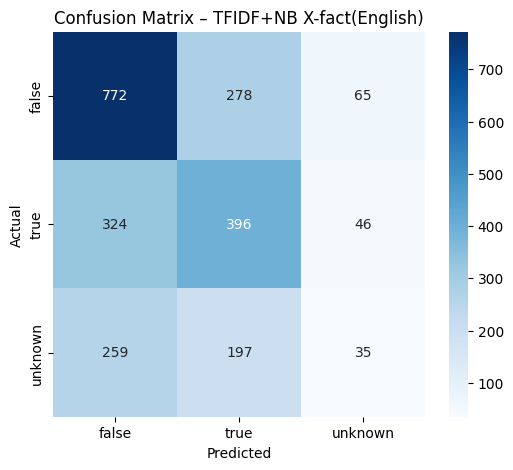

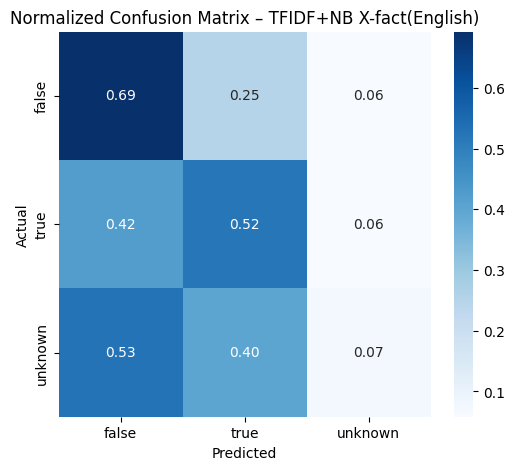

In [ ]:
cm_nb_en = plot_confusion(
    y_true=y_test_en,
    probs=test_probs_nb_en,
    title="Confusion Matrix – TFIDF+NB X-fact(English)"
)

cm_nb_norm_en = plot_confusion(
    y_true=y_test_en,
    probs=test_probs_nb_en,
    normalize=True,
    title="Normalized Confusion Matrix – TFIDF+NB X-fact(English)"
)

In [ ]:
errors_nb_test_en = make_error_table(
    probs=test_probs_nb_en,
    y_true=y_test_en,
    texts=X_test_en,
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_en["language"].tolist(),
    split_name="test_en",
    model_name="TFIDF+NB"
)

In [ ]:
print("Total misclassified examples on X-fact(English):", len(errors_nb_test_en))

Total misclassified examples on X-fact(English): 1169


In [ ]:
nb_errors_path = os.path.join(output_dir, "x_fact_en_nb_test_errors.csv")
errors_nb_test_en.to_csv(nb_errors_path, index=False)

print("Saved NB test errors to:", nb_errors_path)

Saved NB test errors to: /content/drive/MyDrive/misinfo_project/x_fact_en_nb_test_errors.csv


**Cross-lingual Test on Spanish**

In [ ]:
_, _, test_es_cr = filter_language_splits(train_df, val_df, test_df, "es")

Language=es: Train=868, Val=121, Test=256


In [ ]:
X_test_es_cr = test_es_cr[TEXT_COL].tolist()
y_test_es_cr = test_es_cr["labels"].to_numpy()

In [ ]:
metrics_test_nb_es_cr, test_probs_nb_es_cr, test_preds_nb_es_cr = evaluate_sklearn_clf(
    tfidf_nb_clf, X_test_es_cr, y_test_es_cr, "Cross-lingual Test (TFIDF+NB) on Spanish, EN->ES")


=== Cross-lingual Test (TFIDF+NB) on Spanish, EN->ES ===
Macro-F1     : 0.24348037783620605
Macro AUPRC  : 0.36054573858843164
Micro AUPRC  : 0.39971283383237965
ECE          : 0.051690076175781696

              precision    recall  f1-score   support

       false       0.45      0.82      0.58       116
        true       0.21      0.03      0.05       112
     unknown       0.09      0.11      0.10        28

    accuracy                           0.39       256
   macro avg       0.25      0.32      0.24       256
weighted avg       0.31      0.39      0.30       256



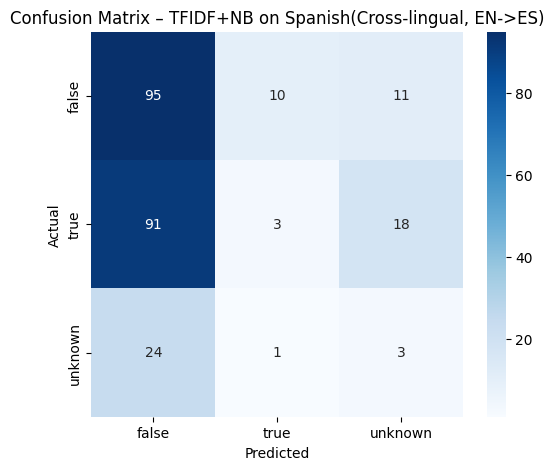

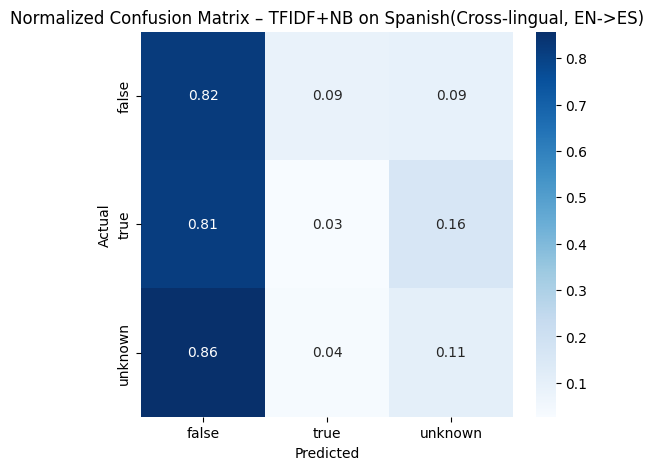

In [ ]:
cm_nb_es = plot_confusion(
    y_true=y_test_es_cr,
    probs=test_probs_nb_es_cr,
    title="Confusion Matrix – TFIDF+NB on Spanish(Cross-lingual, EN->ES)"
)

cm_nb_es_norm = plot_confusion(
    y_true=y_test_es_cr,
    probs=test_probs_nb_es_cr,
    normalize=True,
    title="Normalized Confusion Matrix – TFIDF+NB on Spanish(Cross-lingual, EN->ES)"
)

In [ ]:
errors_nb_test_es_cr = make_error_table(
    probs=test_probs_nb_es_cr,
    y_true=y_test_es_cr,
    texts=X_test_es_cr,
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_es_cr["language"].tolist(),
    split_name="test_es_cross",
    model_name="TFIDF+NB (EN->ES)"
)

In [ ]:
print("Total misclassified examples Spanish(Cross-lingual):", len(errors_nb_test_es_cr))

Total misclassified examples Spanish(Cross-lingual): 155


In [ ]:
nb_errors_path = os.path.join(output_dir, "x_fact_es_cr_nb_test_errors.csv")
errors_nb_test_es_cr.to_csv(nb_errors_path, index=False)

print("Saved NB test errors to:", nb_errors_path)

Saved NB test errors to: /content/drive/MyDrive/misinfo_project/x_fact_es_cr_nb_test_errors.csv


**Only Spanish: Training and Evaluation**

In [ ]:
train_es, val_es, test_es = filter_language_splits(train_df, val_df, test_df, "es")

Language=es: Train=868, Val=121, Test=256


In [ ]:
X_train_es = train_es[TEXT_COL].tolist()
y_train_es = train_es["labels"].to_numpy()
X_val_es   = val_es[TEXT_COL].tolist()
y_val_es   = val_es["labels"].to_numpy()
X_test_es  = test_es[TEXT_COL].tolist()
y_test_es  = test_es["labels"].to_numpy()

In [ ]:
tfidf_nb_clf.fit(X_train_es, y_train_es)

In [ ]:
metrics_train_nb_es, train_probs_nb_es, train_preds_nb_es = evaluate_sklearn_clf(
    tfidf_nb_clf, X_train_es, y_train_es, "Train (TFIDF+NB) on X-fact(Spanish)"
)
metrics_val_nb_es,   val_probs_nb_es,   val_preds_nb_es   = evaluate_sklearn_clf(
    tfidf_nb_clf, X_val_es,   y_val_es,   "Validation (TFIDF+NB) on X-fact(Spanish)"
)
metrics_test_nb_es,  test_probs_nb_es,  test_preds_nb_es = evaluate_sklearn_clf(
    tfidf_nb_clf, X_test_es,  y_test_es,  "Test (TFIDF+NB) on X-fact(Spanish)"
)


=== Train (TFIDF+NB) on X-fact(Spanish) ===
Macro-F1     : 0.8652871053434862
Macro AUPRC  : 0.9312921503985901
Micro AUPRC  : 0.9419060591409592
ECE          : 0.4078621343771517

              precision    recall  f1-score   support

       false       0.87      0.88      0.87       379
        true       0.87      0.88      0.88       399
     unknown       0.87      0.82      0.85        90

    accuracy                           0.87       868
   macro avg       0.87      0.86      0.87       868
weighted avg       0.87      0.87      0.87       868


=== Validation (TFIDF+NB) on X-fact(Spanish) ===
Macro-F1     : 0.3352118829183049
Macro AUPRC  : 0.38056502561915045
Micro AUPRC  : 0.4497327113419355
ECE          : 0.07543604409711172

              precision    recall  f1-score   support

       false       0.52      0.44      0.48        59
        true       0.41      0.52      0.46        46
     unknown       0.08      0.06      0.07        16

    accuracy                  

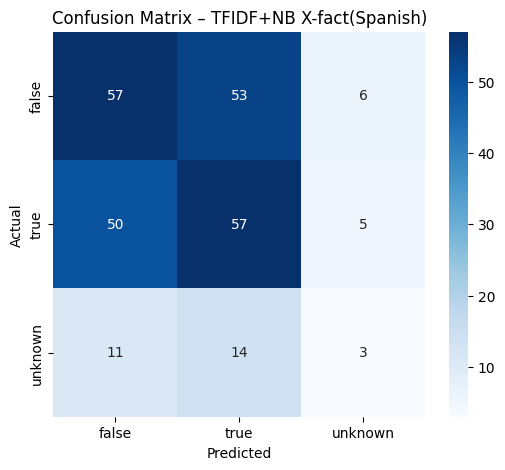

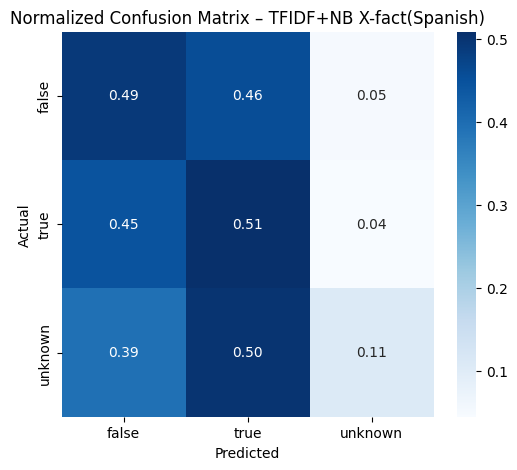

In [ ]:
cm_nb_es = plot_confusion(
    y_true=y_test_es,
    probs=test_probs_nb_es,
    title="Confusion Matrix – TFIDF+NB X-fact(Spanish)"
)

cm_nb_norm_es = plot_confusion(
    y_true=y_test_es,
    probs=test_probs_nb_es,
    normalize=True,
    title="Normalized Confusion Matrix – TFIDF+NB X-fact(Spanish)"
)

In [ ]:
errors_nb_test_es_mono = make_error_table(
    probs=test_probs_nb_es,
    y_true=y_test_es,
    texts=X_test_es,
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_es["language"].tolist(),
    split_name="test_es",
    model_name="TFIDF+NB(ES)"
)

In [ ]:
print("Total misclassified examples on X-fact(Spanish):", len(errors_nb_test_es_mono))

Total misclassified examples on X-fact(Spanish): 139


In [ ]:
nb_errors_path = os.path.join(output_dir, "x_fact_es_mono_nb_test_errors.csv")
errors_nb_test_es_mono.to_csv(nb_errors_path, index=False)

print("Saved NB test errors to:", nb_errors_path)

Saved NB test errors to: /content/drive/MyDrive/misinfo_project/x_fact_es_mono_nb_test_errors.csv


**Only Polish: Training and Evaluation**

In [ ]:
train_pl, val_pl, test_pl = filter_language_splits(train_df, val_df, test_df, "pl")

Language=pl: Train=1216, Val=173, Test=373


In [ ]:
X_train_pl = train_pl[TEXT_COL].tolist()
y_train_pl = train_pl["labels"].to_numpy()
X_val_pl   = val_pl[TEXT_COL].tolist()
y_val_pl   = val_pl["labels"].to_numpy()
X_test_pl  = test_pl[TEXT_COL].tolist()
y_test_pl  = test_pl["labels"].to_numpy()

In [ ]:
print(X_train_pl[0])
print(y_train_pl[0])

(...) okazuje się, że ponad 30% osób w polsce deklaruje, że będzie się szczepiło przeciwko koronawirusowi (...).
0


In [ ]:
tfidf_nb_clf.fit(X_train_pl, y_train_pl)

In [ ]:
metrics_train_nb_pl, train_probs_nb_pl, train_preds_nb_pl = evaluate_sklearn_clf(
    tfidf_nb_clf, X_train_pl, y_train_pl, "Train (TFIDF+NB) on X-fact(Polish)"
)
metrics_val_nb_pl, val_probs_nb_pl, val_preds_nb_pl = evaluate_sklearn_clf(
    tfidf_nb_clf, X_val_pl, y_val_pl, "Validation (TFIDF+NB) on X-fact(Polish)"
)
metrics_test_nb_pl,  test_probs_nb_pl,  test_preds_nb_pl  = evaluate_sklearn_clf(
    tfidf_nb_clf, X_test_pl, y_test_pl, "Test (TFIDF+NB) on X-fact(Polish)"
)


=== Train (TFIDF+NB) on X-fact(Polish) ===
Macro-F1     : 0.9306148035294864
Macro AUPRC  : 0.9578533670657018
Micro AUPRC  : 0.9786162714386666
ECE          : 0.47183645088122667

              precision    recall  f1-score   support

       false       0.94      0.93      0.94       448
        true       0.95      0.96      0.96       707
     unknown       0.93      0.87      0.90        61

    accuracy                           0.95      1216
   macro avg       0.94      0.92      0.93      1216
weighted avg       0.95      0.95      0.95      1216


=== Validation (TFIDF+NB) on X-fact(Polish) ===
Macro-F1     : 0.34619239701747956
Macro AUPRC  : 0.3942598477967887
Micro AUPRC  : 0.5475749696032399
ECE          : 0.09479802412424304

              precision    recall  f1-score   support

       false       0.45      0.38      0.41        73
        true       0.58      0.67      0.62        94
     unknown       0.00      0.00      0.00         6

    accuracy                   

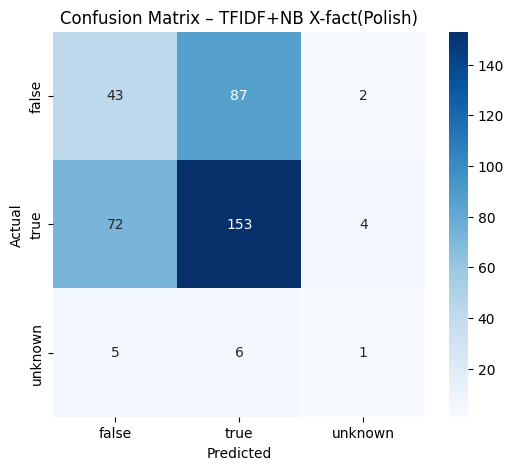

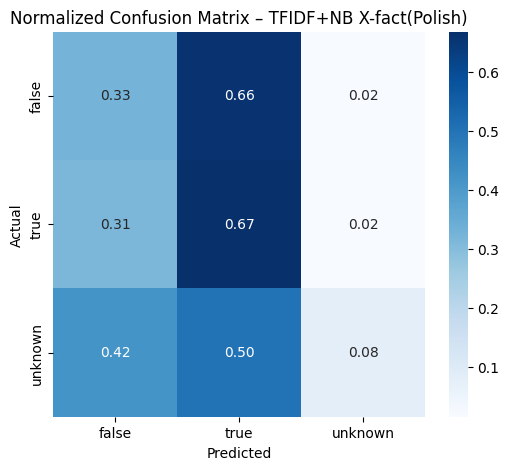

In [ ]:
cm_nb_pl = plot_confusion(
    y_true=y_test_pl,
    probs=test_probs_nb_pl,
    title="Confusion Matrix – TFIDF+NB X-fact(Polish)"
)
cm_nb_norm_pl = plot_confusion(
    y_true=y_test_pl,
    probs=test_probs_nb_pl,
    normalize=True,
    title="Normalized Confusion Matrix – TFIDF+NB X-fact(Polish)"
)

In [ ]:
errors_nb_test_pl = make_error_table(
    probs=test_probs_nb_pl,
    y_true=y_test_pl,
    texts=X_test_pl,
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_pl["language"].tolist(),
    split_name="test_pl",
    model_name="TFIDF+NB(PL)"
)

In [ ]:
print("Total misclassified examples on X-fact(Polish):", len(errors_nb_test_pl))

Total misclassified examples on X-fact(Polish): 176


In [ ]:
errors_nb_test_pl.head()

,idx,text,actual,pred,conf,language,split,model,p_false,p_true,p_unknown
0,1,1/3 populacji cierpi na brak dobrej wody.,true,false,0.397047,pl,test_pl,TFIDF+NB(PL),0.397047,0.319565,0.283389
1,3,(…) cztery lata temu my [psl – przyp. red.] mi...,true,false,0.436291,pl,test_pl,TFIDF+NB(PL),0.436291,0.326125,0.237584
2,6,180 tys. osób więcej (za kadencji andrzeja dud...,true,false,0.463195,pl,test_pl,TFIDF+NB(PL),0.463195,0.252226,0.284579
3,10,300 lat temu przyjeliśmy do poznania bambrów (...,true,false,0.406295,pl,test_pl,TFIDF+NB(PL),0.406295,0.367648,0.226057
4,12,736 albo 737 etatów na dzisiaj jest nieobsadzo...,unknown,false,0.418505,pl,test_pl,TFIDF+NB(PL),0.418505,0.323064,0.258431


In [ ]:
nb_errors_path = os.path.join(output_dir, "x_fact_pl_nb_test_errors.csv")
errors_nb_test_pl.to_csv(nb_errors_path, index=False)

print("Saved NB test errors to:", nb_errors_path)

Saved NB test errors to: /content/drive/MyDrive/misinfo_project/x_fact_pl_nb_test_errors.csv


## **FastText Embeddings + MLP**

The second model is a **shallow neural model** that uses pre-trained **FastText** word embeddings combined with a small MLP:

1. **Tokenization & Embeddings**
   - Each claim is tokenized with `nltk.word_tokenize`.
   - **Only alphabetic** tokens are retained, and a **300-dimensional** FastText vector is obtained for each token.
   - Token vectors are **averaged** to produce a single sentence embedding per claim, followed by **L2-normalization**.

2. **MLP Architecture**
   - Input: 300-dim sentence vector.
   - Two hidden layers of size 256 and 128 with **ReLU** activations.
   - **Dropout (0.3)** after each hidden layer to reduce overfitting.
   - Output: 3-way softmax for `false`, `true`, `unknown`.

3. **Training Details**
   - Loss: Cross-entropy with **class weights** derived from the training label distribution to counter imbalance.
   - Optimizer: Adam with learning rate `1e-3`.
   - Strategy: up to **100 epochs** with **early stopping** based on validation macro-F1.

After training, the model is evaluated with the same metrics (Macro-F1, AUPRC, ECE, confusion matrices, error tables) to see how much a shallow neural approach improves over the lexical baseline.


In [ ]:
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
def tokenize(text):
    tokens = nltk.word_tokenize(text.lower())
    return [token for token in tokens if token.isalpha()]

In [ ]:
def sent_to_vec(tokens, model, dim):
    vecs = [model[w] for w in tokens if w in model]
    if not vecs:
        return np.zeros(dim, dtype=np.float32)
    v = np.mean(vecs, axis=0)

    norm = np.linalg.norm(v)
    if norm > 0:
        v = v / norm

    return v.astype(np.float32)

def build_features(df, text_col, model, dim):
    X = np.vstack([
        sent_to_vec(tokenize(t), model, dim)
        for t in df[text_col].tolist()
    ])
    y = df["labels"].to_numpy()
    return X, y

In [ ]:
X_train_ft_en, y_train_ft_en = build_features(train_en, TEXT_COL, fasttext_model, 300)
X_val_ft_en, y_val_ft_en = build_features(val_en, TEXT_COL, fasttext_model, 300)
X_test_ft_en, y_test_ft_en = build_features(test_en, TEXT_COL, fasttext_model, 300)

In [ ]:
X_train_ft_en.shape

(8487, 300)

In [ ]:
class FT_Dataset(TorchDataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __getitems__(self, indices):
        return [self.__getitem__(i) for i in indices]

train_ds_en = FT_Dataset(X_train_ft_en, y_train_ft_en)
val_ds_en = FT_Dataset(X_val_ft_en, y_val_ft_en)
test_ds_en = FT_Dataset(X_test_ft_en, y_test_ft_en)

In [ ]:
train_loader_en = DataLoader(train_ds_en, batch_size=256, shuffle=True)
val_loader_en = DataLoader(val_ds_en, batch_size=256, shuffle=False)
test_loader_en = DataLoader(test_ds_en, batch_size=256, shuffle=False)

In [ ]:
class FastTextMLP(nn.Module):
    def __init__(self, input_dim=300, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

In [ ]:
num_classes = len(CLASS_IDS)

class_counts_en = np.bincount(y_train_en, minlength=num_classes).astype(np.float32)
print("Counts:", class_counts_en)

# inverse-frequency style weights
class_weights_en = class_counts_en.sum() / (num_classes * class_counts_en)
print("Weights:", class_weights_en)

class_weights_t_en = torch.tensor(class_weights_en, dtype=torch.float32).to(device)

Counts: [3975. 2853. 1659.]
Weights: [0.7116981 0.9915878 1.7052441]


In [ ]:
model = FastTextMLP().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_t_en)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(y.cpu().numpy())
            total_loss += loss.item()
    return (total_loss / len(loader),
            np.vstack(all_probs),
            np.concatenate(all_labels))


In [ ]:
best_f1 = 0.0
best_val_loss = float("inf")
patience = 10
wait = 0
EPOCHS = 100
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader_en)
    val_loss, val_probs, val_labels = eval_epoch(model, val_loader_en)
    val_preds = val_probs.argmax(axis=1)
    val_macro_f1 = f1_score(val_labels, val_preds, average="macro")

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Macro F1: {val_macro_f1:.4f}")

    if val_macro_f1 > best_f1:
        best_f1 = val_macro_f1
        wait = 0
        best_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_state)

Epoch 01 | Train Loss: 1.0966 | Val Loss: 1.0898 | Val Macro F1: 0.3649
Epoch 02 | Train Loss: 1.0804 | Val Loss: 1.0711 | Val Macro F1: 0.3982
Epoch 03 | Train Loss: 1.0684 | Val Loss: 1.0657 | Val Macro F1: 0.3841
Epoch 04 | Train Loss: 1.0609 | Val Loss: 1.0693 | Val Macro F1: 0.4011
Epoch 05 | Train Loss: 1.0585 | Val Loss: 1.0600 | Val Macro F1: 0.4376
Epoch 06 | Train Loss: 1.0535 | Val Loss: 1.0612 | Val Macro F1: 0.4388
Epoch 07 | Train Loss: 1.0513 | Val Loss: 1.0577 | Val Macro F1: 0.4411
Epoch 08 | Train Loss: 1.0386 | Val Loss: 1.0579 | Val Macro F1: 0.4344
Epoch 09 | Train Loss: 1.0382 | Val Loss: 1.0622 | Val Macro F1: 0.4339
Epoch 10 | Train Loss: 1.0359 | Val Loss: 1.0595 | Val Macro F1: 0.4274
Epoch 11 | Train Loss: 1.0323 | Val Loss: 1.0574 | Val Macro F1: 0.4380
Epoch 12 | Train Loss: 1.0264 | Val Loss: 1.0617 | Val Macro F1: 0.4208
Epoch 13 | Train Loss: 1.0215 | Val Loss: 1.0683 | Val Macro F1: 0.4287
Epoch 14 | Train Loss: 1.0173 | Val Loss: 1.0723 | Val Macro F1:

<All keys matched successfully>

In [ ]:
train_loss_en, train_probs_en, train_labels_en = eval_epoch(model, train_loader_en)
val_loss_en, val_probs_en,   val_labels_en  = eval_epoch(model, val_loader_en)
test_loss_en,  test_probs_en,  test_labels_en  = eval_epoch(model, test_loader_en)

print(f"\nTrain loss: {train_loss_en:.4f}")
metrics_train_mlp_en = evaluate_probs(train_probs_en, train_labels_en, "Train (FT+MLP)  on X-fact(English)", CLASS_IDS, id2label, n_bins=15)

print(f"\nValidation loss: {val_loss_en:.4f}")
metrics_val_mlp_en  = evaluate_probs(val_probs_en, val_labels_en, "Validation (FT+MLP)  on X-fact(English)", CLASS_IDS, id2label, n_bins=15)

print(f"\nTest loss: {test_loss_en:.4f}")
metrics_test_mlp_en = evaluate_probs(test_probs_en,  test_labels_en, "Test (FT+MLP) on X-fact(English)", CLASS_IDS, id2label, n_bins=15)


Train loss: 0.9939

=== Train (FT+MLP)  on X-fact(English) ===
Macro-F1     : 0.48931270294234236
Macro AUPRC  : 0.5226922745002857
Micro AUPRC  : 0.5565410222818465
ECE          : 0.04196469777040829

              precision    recall  f1-score   support

       false       0.70      0.47      0.56      3975
        true       0.50      0.58      0.54      2853
     unknown       0.30      0.47      0.37      1659

    accuracy                           0.51      8487
   macro avg       0.50      0.50      0.49      8487
weighted avg       0.56      0.51      0.52      8487


Validation loss: 1.0626

=== Validation (FT+MLP)  on X-fact(English) ===
Macro-F1     : 0.4243131601314565
Macro AUPRC  : 0.4371713046573376
Micro AUPRC  : 0.47380479535600245
ECE          : 0.04293874354254554

              precision    recall  f1-score   support

       false       0.62      0.44      0.51       563
        true       0.47      0.51      0.49       440
     unknown       0.22      0.34      0

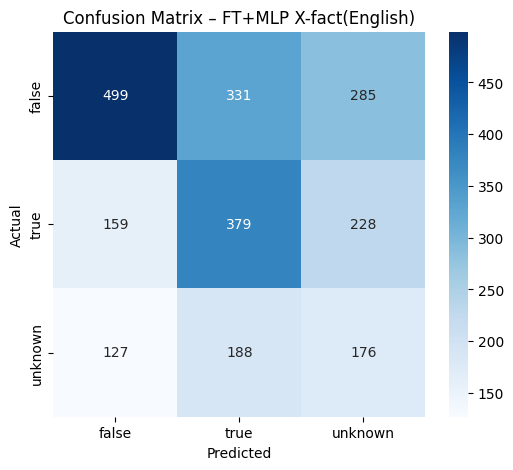

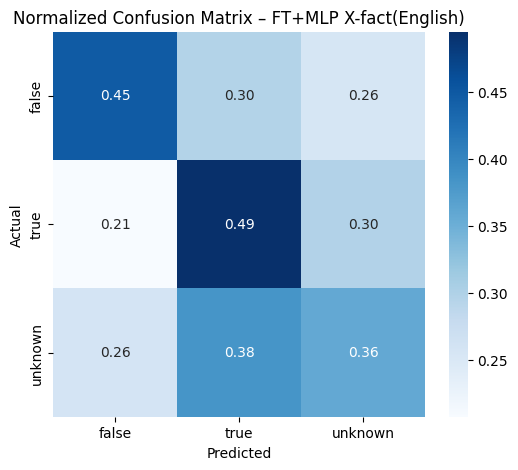

In [ ]:
cm_ft = plot_confusion(
    y_true=test_labels_en,
    probs=test_probs_en,
    title="Confusion Matrix – FT+MLP X-fact(English)"
)

cm_ft_norm = plot_confusion(
    y_true=test_labels_en,
    probs=test_probs_en,
    normalize=True,
    title="Normalized Confusion Matrix – FT+MLP X-fact(English)"
)

In [ ]:
errors_FT_MLP_test_en = make_error_table(
    probs=test_probs_en,
    y_true=test_labels_en,
    texts=test_df[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_en["language"].tolist(),
    split_name="test_en",
    model_name="FastText+MLP(EN)"
)

In [ ]:
FT_MLP_errors_path = os.path.join(output_dir, "x_fact_en_FT_MLP_test_errors.csv")
errors_FT_MLP_test_en.to_csv(FT_MLP_errors_path, index=False)

print("Saved FT+MLP test errors to:", FT_MLP_errors_path)

Saved FT+MLP test errors to: /content/drive/MyDrive/misinfo_project/x_fact_en_FT_MLP_test_errors.csv


In [ ]:
errors_FT_MLP_test_en.head()

,idx,text,actual,pred,conf,language,split,model,p_false,p_true,p_unknown
0,1,""" ‘obamacare’ puts the federal government betw...",true,unknown,0.401174,en,test_en,FastText+MLP(EN),0.269436,0.329390,0.401174
1,3,"""$120,000 will be spent by taxpayers on charli...",true,false,0.402927,en,test_en,FastText+MLP(EN),0.402927,0.199995,0.397078
2,4,"""$360 million of our tax dollars went straight...",true,unknown,0.414191,en,test_en,FastText+MLP(EN),0.238484,0.347326,0.414191
3,5,"""$500 billion of the extension of the bush tax...",false,true,0.397577,en,test_en,FastText+MLP(EN),0.354550,0.397577,0.247873
4,6,"""(birmingham, ala.) is the cradle of the civil...",true,false,0.527253,en,test_en,FastText+MLP(EN),0.527253,0.207336,0.265411


In [ ]:
print("Total misclassified examples on X-fact(English):", len(errors_FT_MLP_test_en))

Total misclassified examples on X-fact(English): 1318


**Cross-lingual Test on Spanish**

In [ ]:
X_test_es_cr_ft, y_test_es_cr_ft = build_features(test_es_cr, TEXT_COL, fasttext_model, 300)

In [ ]:
X_test_es_cr_ft.shape

(256, 300)

In [ ]:
test_ds_es_cr = FT_Dataset(X_test_es_cr_ft, y_test_es_cr_ft)

In [ ]:
test_loader_es_cr = DataLoader(test_ds_es_cr, batch_size=256, shuffle=False)

In [ ]:
test_loss_es_cr, test_probs_es_cr, test_labels_es_cr = eval_epoch(model, test_loader_es_cr)
print(f"\nTest loss: {test_loss_es_cr:.4f}")
metrics_test_mlp_es_cr  = evaluate_probs(test_probs_es_cr,  test_labels_es_cr,  "Cross-lingual(EN->ES) Test (FT+MLP) on X-fact(Spanish)", CLASS_IDS, id2label, n_bins=15)


Test loss: 1.2759

=== Cross-lingual(EN->ES) Test (FT+MLP) on X-fact(Spanish) ===
Macro-F1     : 0.2525704809286899
Macro AUPRC  : 0.3567370751670458
Micro AUPRC  : 0.4098864435977996
ECE          : 0.13409917114768177

              precision    recall  f1-score   support

       false       0.45      0.85      0.59       116
        true       0.55      0.10      0.17       112
     unknown       0.00      0.00      0.00        28

    accuracy                           0.43       256
   macro avg       0.33      0.32      0.25       256
weighted avg       0.45      0.43      0.34       256



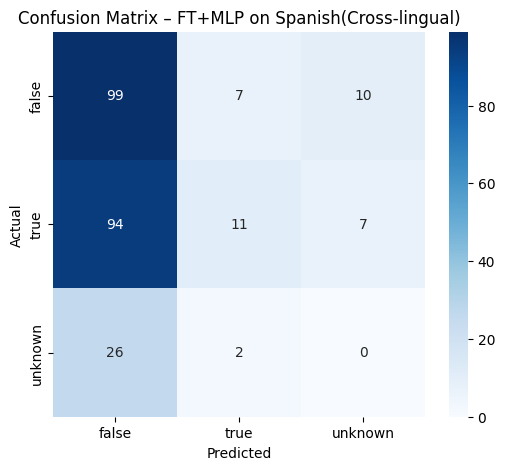

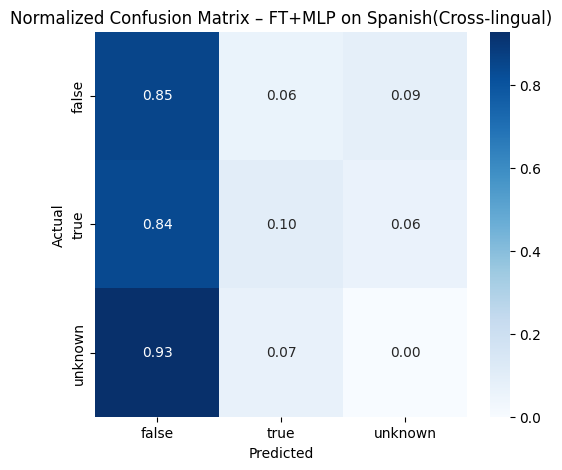

In [ ]:
cm_ft_es_cr = plot_confusion(
    y_true=test_labels_es_cr,
    probs=test_probs_es_cr,
    title="Confusion Matrix – FT+MLP on Spanish(Cross-lingual)"
)

cm_ft_es_cr = plot_confusion(
    y_true=test_labels_es_cr,
    probs=test_probs_es_cr,
    normalize=True,
    title="Normalized Confusion Matrix – FT+MLP on Spanish(Cross-lingual)"
)

In [ ]:
errors_FT_MLP_test_es_cr = make_error_table(
    probs=test_probs_es_cr,
    y_true=test_labels_es_cr,
    texts=test_es_cr[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_es_cr["language"].tolist(),
    split_name="test_es_cross",
    model_name="FastText+MLP(EN->ES)"
)

In [ ]:
FT_MLP_errors_path = os.path.join(output_dir, "x_fact_es_cr_FT_MLP_test_errors.csv")
errors_FT_MLP_test_es_cr.to_csv(FT_MLP_errors_path, index=False)

print("Saved FT+MLP test errors to:", FT_MLP_errors_path)

Saved FT+MLP test errors to: /content/drive/MyDrive/misinfo_project/x_fact_es_cr_FT_MLP_test_errors.csv


In [ ]:
print("Total misclassified examples Spanish(Cross-lingual):", len(errors_FT_MLP_test_es_cr))

Total misclassified examples Spanish(Cross-lingual): 146


**Only Spanish: Training and Evaluation**

In [ ]:
X_train_es_ft, y_train_es_ft = build_features(train_es, TEXT_COL, fasttext_model, 300)
X_val_es_ft, y_val_es_ft = build_features(val_es, TEXT_COL, fasttext_model, 300)
X_test_es_ft, y_test_es_ft = build_features(test_es, TEXT_COL, fasttext_model, 300)

In [ ]:
X_train_es_ft.shape

(868, 300)

In [ ]:
train_ds_es = FT_Dataset(X_train_es_ft, y_train_es_ft)
val_ds_es = FT_Dataset(X_val_es_ft, y_val_es_ft)
test_ds_es = FT_Dataset(X_test_es_ft, y_test_es_ft)

In [ ]:
train_loader_es = DataLoader(train_ds_es, batch_size=256, shuffle=True)
val_loader_es = DataLoader(val_ds_es, batch_size=256, shuffle=False)
test_loader_es = DataLoader(test_ds_es, batch_size=256, shuffle=False)

In [ ]:
class_counts_es = np.bincount(y_train_es, minlength=num_classes).astype(np.float32)
print("Counts:", class_counts_es)

class_weights_es = class_counts_es.sum() / (num_classes * class_counts_es)
print("Weights:", class_weights_es)

class_weights_t_es = torch.tensor(class_weights_es, dtype=torch.float32).to(device)

Counts: [379. 399.  90.]
Weights: [0.7634125 0.7251462 3.214815 ]


In [ ]:
model = FastTextMLP().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_t_es)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
best_f1 = 0.0
best_val_loss = float("inf")
patience = 10
wait = 0
EPOCHS = 100
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader_es)
    val_loss, val_probs, val_labels = eval_epoch(model, val_loader_es)
    val_preds = val_probs.argmax(axis=1)
    val_macro_f1 = f1_score(val_labels, val_preds, average="macro")

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Macro F1: {val_macro_f1:.4f}")

    if val_macro_f1 > best_f1:
        best_f1 = val_macro_f1
        wait = 0
        best_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_state)

Epoch 01 | Train Loss: 1.1020 | Val Loss: 1.1058 | Val Macro F1: 0.2699
Epoch 02 | Train Loss: 1.0985 | Val Loss: 1.1014 | Val Macro F1: 0.2185
Epoch 03 | Train Loss: 1.0994 | Val Loss: 1.1005 | Val Macro F1: 0.2185
Epoch 04 | Train Loss: 1.0977 | Val Loss: 1.0984 | Val Macro F1: 0.2467
Epoch 05 | Train Loss: 1.0976 | Val Loss: 1.0986 | Val Macro F1: 0.3690
Epoch 06 | Train Loss: 1.0962 | Val Loss: 1.0979 | Val Macro F1: 0.1160
Epoch 07 | Train Loss: 1.0942 | Val Loss: 1.0976 | Val Macro F1: 0.1803
Epoch 08 | Train Loss: 1.0959 | Val Loss: 1.0983 | Val Macro F1: 0.2885
Epoch 09 | Train Loss: 1.0927 | Val Loss: 1.0991 | Val Macro F1: 0.2930
Epoch 10 | Train Loss: 1.0914 | Val Loss: 1.0992 | Val Macro F1: 0.2838
Epoch 11 | Train Loss: 1.0901 | Val Loss: 1.0980 | Val Macro F1: 0.3028
Epoch 12 | Train Loss: 1.0857 | Val Loss: 1.1038 | Val Macro F1: 0.3410
Epoch 13 | Train Loss: 1.0879 | Val Loss: 1.1054 | Val Macro F1: 0.3639
Epoch 14 | Train Loss: 1.0806 | Val Loss: 1.1032 | Val Macro F1:

<All keys matched successfully>

In [ ]:
train_loss_es, train_probs_es, train_labels_es = eval_epoch(model, train_loader_es)
val_loss_es,   val_probs_es,   val_labels_es   = eval_epoch(model, val_loader_es)
test_loss_es,  test_probs_es,  test_labels_es  = eval_epoch(model, test_loader_es)

print(f"\nTrain loss: {train_loss_es:.4f}")
metrics_train_mlp_es = evaluate_probs(train_probs_es, train_labels_es, "Train (FT+MLP) on X-fact(Spanish)", CLASS_IDS, id2label, n_bins=15)

print(f"\nValidation loss: {val_loss_es:.4f}")
metrics_val_mlp_es = evaluate_probs(val_probs_es, val_labels_es, "Validation (FT+MLP) on X-fact(Spanish)", CLASS_IDS, id2label, n_bins=15)

print(f"\nTest loss: {test_loss_es:.4f}")
metrics_test_mlp_es = evaluate_probs(test_probs_es, test_labels_es, "Test (FT+MLP) on X-fact(Spanish)", CLASS_IDS, id2label, n_bins=15)


Train loss: 1.0736

=== Train (FT+MLP) on X-fact(Spanish) ===
Macro-F1     : 0.39211427249494385
Macro AUPRC  : 0.43422421059824906
Micro AUPRC  : 0.39627890121050136
ECE          : 0.051475372457284514

              precision    recall  f1-score   support

       false       0.54      0.40      0.46       379
        true       0.56      0.39      0.46       399
     unknown       0.17      0.58      0.26        90

    accuracy                           0.41       868
   macro avg       0.42      0.45      0.39       868
weighted avg       0.51      0.41      0.44       868


Validation loss: 1.1068

=== Validation (FT+MLP) on X-fact(Spanish) ===
Macro-F1     : 0.312212039724022
Macro AUPRC  : 0.328485695590463
Micro AUPRC  : 0.3250680971596341
ECE          : 0.03063682903928203

              precision    recall  f1-score   support

       false       0.55      0.39      0.46        59
        true       0.28      0.22      0.24        46
     unknown       0.16      0.44      0.2

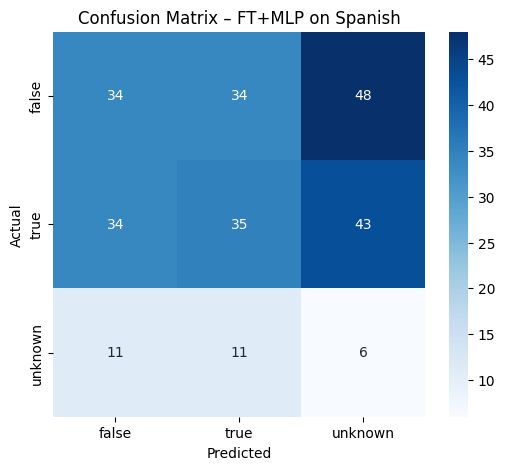

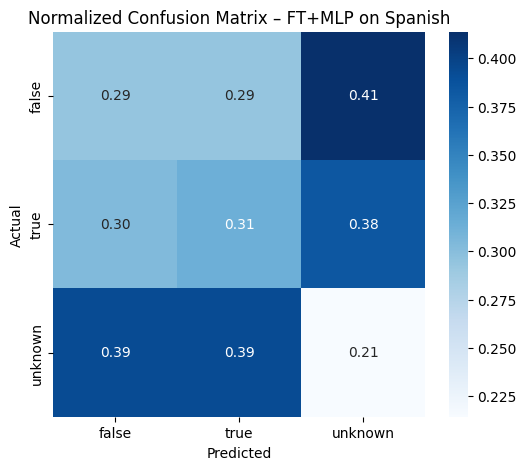

In [ ]:
cm_ft_es = plot_confusion(
    y_true=test_labels_es,
    probs=test_probs_es,
    title="Confusion Matrix – FT+MLP on Spanish"
)

cm_ft_es_norm = plot_confusion(
    y_true=test_labels_es,
    probs=test_probs_es,
    normalize=True,
    title="Normalized Confusion Matrix – FT+MLP on Spanish"
)

In [ ]:
errors_FT_MLP_test_es = make_error_table(
    probs=test_probs_es,
    y_true=test_labels_es,
    texts=test_es[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_es["language"].tolist(),
    split_name="test_es",
    model_name="FastText+MLP(ES)"
)

In [ ]:
FT_MLP_errors_path = os.path.join(output_dir, "x_fact_es_FT_MLP_test_errors.csv")
errors_FT_MLP_test_es.to_csv(FT_MLP_errors_path, index=False)

print("Saved FT+MLP test errors to:", FT_MLP_errors_path)

Saved FT+MLP test errors to: /content/drive/MyDrive/misinfo_project/x_fact_es_FT_MLP_test_errors.csv


In [ ]:
print("Total misclassified examples on X-fact(Spanish):", len(errors_FT_MLP_test_es))

Total misclassified examples on X-fact(Spanish): 181


**Only Polish: Training and Evaluation**

In [ ]:
X_train_pl_ft, y_train_pl_ft = build_features(train_pl, TEXT_COL, fasttext_model, 300)
X_val_pl_ft, y_val_pl_ft = build_features(val_pl, TEXT_COL, fasttext_model, 300)
X_test_pl_ft, y_test_pl_ft = build_features(test_pl, TEXT_COL, fasttext_model, 300)

In [ ]:
X_train_pl_ft.shape

(1216, 300)

In [ ]:
train_ds_pl = FT_Dataset(X_train_pl_ft, y_train_pl_ft)
val_ds_pl = FT_Dataset(X_val_pl_ft, y_val_pl_ft)
test_ds_pl = FT_Dataset(X_test_pl_ft, y_test_pl_ft)

In [ ]:
train_loader_pl = DataLoader(train_ds_pl, batch_size=256, shuffle=True)
val_loader_pl = DataLoader(val_ds_pl, batch_size=256, shuffle=False)
test_loader_pl = DataLoader(test_ds_pl, batch_size=256, shuffle=False)

In [ ]:
class_counts_pl = np.bincount(y_train_pl, minlength=num_classes).astype(np.float32)
print("Counts:", class_counts_pl)

class_weights_pl = class_counts_pl.sum() / (num_classes * class_counts_pl)
print("Weights:", class_weights_pl)

class_weights_t_pl = torch.tensor(class_weights_pl, dtype=torch.float32).to(device)

Counts: [448. 707.  61.]
Weights: [0.9047619 0.5733145 6.644809 ]


In [ ]:
model = FastTextMLP().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_t_pl)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
best_f1 = 0.0
best_val_loss = float("inf")
patience = 10
wait = 0
EPOCHS = 100
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader_pl)
    val_loss, val_probs, val_labels = eval_epoch(model, val_loader_pl)
    val_preds = val_probs.argmax(axis=1)
    val_macro_f1 = f1_score(val_labels, val_preds, average="macro")

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Macro F1: {val_macro_f1:.4f}")

    if val_macro_f1 > best_f1:
        best_f1 = val_macro_f1
        wait = 0
        best_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_state)

Epoch 01 | Train Loss: 1.1007 | Val Loss: 1.0922 | Val Macro F1: 0.1978
Epoch 02 | Train Loss: 1.0979 | Val Loss: 1.0949 | Val Macro F1: 0.2980
Epoch 03 | Train Loss: 1.0975 | Val Loss: 1.0973 | Val Macro F1: 0.2574
Epoch 04 | Train Loss: 1.0972 | Val Loss: 1.0975 | Val Macro F1: 0.3043
Epoch 05 | Train Loss: 1.0976 | Val Loss: 1.0970 | Val Macro F1: 0.2929
Epoch 06 | Train Loss: 1.0973 | Val Loss: 1.0935 | Val Macro F1: 0.2386
Epoch 07 | Train Loss: 1.0933 | Val Loss: 1.0952 | Val Macro F1: 0.2902
Epoch 08 | Train Loss: 1.0931 | Val Loss: 1.0970 | Val Macro F1: 0.3092
Epoch 09 | Train Loss: 1.0919 | Val Loss: 1.0945 | Val Macro F1: 0.2980
Epoch 10 | Train Loss: 1.0914 | Val Loss: 1.0924 | Val Macro F1: 0.3141
Epoch 11 | Train Loss: 1.0868 | Val Loss: 1.0956 | Val Macro F1: 0.3292
Epoch 12 | Train Loss: 1.0864 | Val Loss: 1.0923 | Val Macro F1: 0.3368
Epoch 13 | Train Loss: 1.0825 | Val Loss: 1.0946 | Val Macro F1: 0.2764
Epoch 14 | Train Loss: 1.0724 | Val Loss: 1.0838 | Val Macro F1:

<All keys matched successfully>

In [ ]:
train_loss_pl, train_probs_pl, train_labels_pl = eval_epoch(model, train_loader_pl)
val_loss_pl, val_probs_pl, val_labels_pl = eval_epoch(model, val_loader_pl)
test_loss_pl, test_probs_pl, test_labels_pl = eval_epoch(model, test_loader_pl)

print(f"\nTrain loss: {train_loss_pl:.4f}")
metrics_train_mlp_pl = evaluate_probs(train_probs_pl, train_labels_pl, "Train (FT+MLP)  on X-fact(Polish)", CLASS_IDS, id2label, n_bins=15)

print(f"\nValidation loss: {val_loss_pl:.4f}")
metrics_val_mlp_pl = evaluate_probs(val_probs_pl, val_labels_pl, "Validation (FT+MLP)  on X-fact(Polish)", CLASS_IDS, id2label, n_bins=15)

print(f"\nTest loss: {test_loss_pl:.4f}")
metrics_test_mlp_pl = evaluate_probs(test_probs_pl, test_labels_pl, "Test (FT+MLP) on X-fact(Polish)", CLASS_IDS, id2label, n_bins=15)


Train loss: 0.9595

=== Train (FT+MLP)  on X-fact(Polish) ===
Macro-F1     : 0.38009745669709044
Macro AUPRC  : 0.46877628887133765
Micro AUPRC  : 0.40425991799629907
ECE          : 0.07338733091264178

              precision    recall  f1-score   support

       false       0.50      0.37      0.42       448
        true       0.68      0.42      0.52       707
     unknown       0.11      0.84      0.20        61

    accuracy                           0.42      1216
   macro avg       0.43      0.54      0.38      1216
weighted avg       0.59      0.42      0.47      1216


Validation loss: 1.1026

=== Validation (FT+MLP)  on X-fact(Polish) ===
Macro-F1     : 0.2701997106606581
Macro AUPRC  : 0.3589940083465448
Micro AUPRC  : 0.3553158981253778
ECE          : 0.10485828250129788

              precision    recall  f1-score   support

       false       0.38      0.25      0.30        73
        true       0.55      0.35      0.43        94
     unknown       0.05      0.50      0.

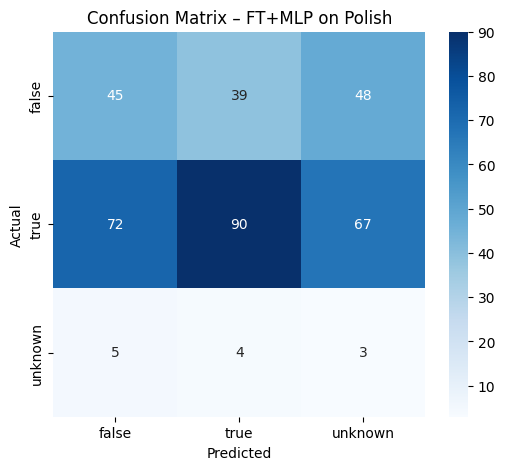

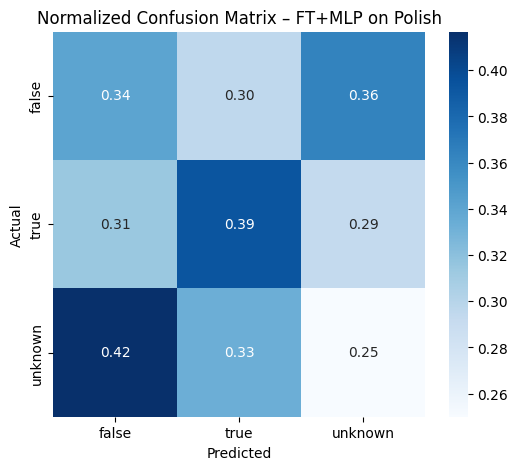

In [ ]:
cm_ft_pl = plot_confusion(
    y_true=test_labels_pl,
    probs=test_probs_pl,
    title="Confusion Matrix – FT+MLP on Polish"
)

cm_ft_pl_norm = plot_confusion(
    y_true=test_labels_pl,
    probs=test_probs_pl,
    normalize=True,
    title="Normalized Confusion Matrix – FT+MLP on Polish"
)

In [ ]:
errors_FT_MLP_test_pl = make_error_table(
    probs=test_probs_pl,
    y_true=test_labels_pl,
    texts=test_pl[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_pl["language"].tolist(),
    split_name="test_pl",
    model_name="FastText+MLP(PL)"
)

In [ ]:
FT_MLP_errors_path = os.path.join(output_dir, "x_fact_pl_FT_MLP_test_errors.csv")
errors_FT_MLP_test_pl.to_csv(FT_MLP_errors_path, index=False)

print("Saved FT+MLP test errors to:", FT_MLP_errors_path)

Saved FT+MLP test errors to: /content/drive/MyDrive/misinfo_project/x_fact_pl_FT_MLP_test_errors.csv


In [ ]:
print("Total misclassified examples on X-fact(Polish):", len(errors_FT_MLP_test_pl))

Total misclassified examples on X-fact(Polish): 235


## **Fine-Tuning XLM-RoBERTa**

The final baseline uses a **transformer-based model**, `xlm-roberta-base`, fine-tuned on the FEVER dataset.

1. **HuggingFace Dataset Conversion**

   * The cleaned pandas DataFrames are converted into HuggingFace `Dataset` objects with the following fields:

     * `text` – the claim,
     * `labels` – the encoded veracity label.

2. **Tokenization**

   * The XLM-R tokenizer is applied with:

     * `max_length = 128`,
     * `padding = "max_length"`,
     * `truncation = True`.
   * Each instance is transformed into `(input_ids, attention_mask, labels)` in PyTorch format.

3. **Model and Training Setup**

   * The base architecture is `xlm-roberta-base`, loaded through `AutoModelForSequenceClassification` with a classification head for 3 labels.
   * A custom `WeightedTrainer` is used, which:

     * applies **class weights** within the cross-entropy loss,
     * computes evaluation metrics such as accuracy, macro-F1, macro/micro AUPRC, and ECE during training.
   * Training arguments include:

     * `learning_rate = 2e-5`,
     * `batch_size = 16`,
     * `num_train_epochs = 5`,
     * `warmup_ratio = 0.1`,
     * `weight_decay = 0.01`,
     * evaluation performed at the end of each epoch.

4. **Evaluation**

   - After fine-tuning, the model is evaluated on the train, validation, and test splits using the shared evaluation utilities.
   - Confusion matrices and detailed error tables are generated for the misclassified test examples.

This setup enables direct comparison between **lexical**, **shallow neural**, and **transformer-based** approaches under a unified evaluation framework.


**Only English: Training and Evaluation**

**Build HuggingFace Dataset objects from the cleaned dataframes**

In [ ]:
train_hf_en = HfDataset.from_pandas(train_en[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))
val_hf_en = HfDataset.from_pandas(val_en[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))
test_hf_en = HfDataset.from_pandas(test_en[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))

In [ ]:
print(train_hf_en[0])

{'text': '" \'denali\' is the kenyan word for \'black power.\' "', 'labels': 0}


**Tokenizer and encodings**

In [ ]:
MODEL_NAME = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
  return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )


train_encodings_en = train_hf_en.map(tokenize, batched=True)
val_encodings_en = val_hf_en.map(tokenize, batched=True)
test_encodings_en = test_hf_en.map(tokenize, batched=True)


train_encodings_en.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_encodings_en.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_encodings_en.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
print(train_encodings_en[0])

**Define model**

In [ ]:
num_labels = len(label2id)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(device)

In [ ]:
metric_acc = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = metric_acc.compute(predictions=preds, references=labels)["accuracy"]
    macro_f1 = f1_score(labels, preds, average="macro")

    probs = torch.softmax(torch.tensor(logits), dim=-1).cpu().numpy()

    auprc_macro, auprc_micro = compute_auprc(probs, labels, class_ids=CLASS_IDS)
    ece = compute_ece(probs, labels, n_bins=15)

    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_auprc": auprc_macro,
        "micro_auprc": auprc_micro,
        "ece": ece,
    }

In [ ]:
def trainer_eval_with_report(trainer, dataset, split_name):
    out = trainer.predict(dataset)
    logits = out.predictions
    y_true = out.label_ids
    probs = torch.softmax(torch.tensor(logits), dim=-1).cpu().numpy()
    metrics, preds = evaluate_probs(
        probs, y_true,
        split_name,
        class_ids=CLASS_IDS,
        id2label=id2label,
        n_bins=15
    )
    return metrics, probs, y_true

In [ ]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss = F.cross_entropy(
            logits, labels,
            weight=self.class_weights.to(logits.device) if self.class_weights is not None else None
        )

        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args_en = TrainingArguments(
    output_dir="/content/drive/MyDrive/misinfo_project/bert_models/x-fact_en_xlmr",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=False,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=200,
    report_to="none",
    save_total_limit=1
)

trainer_en = WeightedTrainer(
    model=model,
    args=training_args_en,
    train_dataset=train_encodings_en,
    eval_dataset=val_encodings_en,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_t_en
)

In [ ]:
trainer_en.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Auprc,Micro Auprc,Ece
1,1.097500,1.087981,0.503638,0.365372,0.415591,0.475478,0.148761
2,1.080000,1.076109,0.438157,0.416557,0.441789,0.427960,0.065223
3,1.048600,1.061377,0.450283,0.432244,0.447531,0.479451,0.050913
4,0.988000,1.065409,0.488278,0.452609,0.460482,0.496909,0.059385
5,0.939400,1.088321,0.459984,0.442576,0.459550,0.489860,0.112805


TrainOutput(global_step=2655, training_loss=1.0282614900118439, metrics={'train_runtime': 248.1043, 'train_samples_per_second': 171.037, 'train_steps_per_second': 10.701, 'total_flos': 2791304470321920.0, 'train_loss': 1.0282614900118439, 'epoch': 5.0})

In [ ]:
metrics_val_xlmr_en  = trainer_eval_with_report(trainer_en, val_encodings_en,  "Validation (XLM-R) on X-fact(English)")
metrics_test_xlmr_en = trainer_eval_with_report(trainer_en, test_encodings_en, "Test (XLM-R) on X-fact(English)")


=== Validation (XLM-R) on X-fact(English) ===
Macro-F1     : 0.44257600992711227
Macro AUPRC  : 0.459550343577547
Micro AUPRC  : 0.48986049537774395
ECE          : 0.11280471529802587

              precision    recall  f1-score   support

       false       0.67      0.42      0.52       563
        true       0.47      0.54      0.50       440
     unknown       0.25      0.40      0.31       234

    accuracy                           0.46      1237
   macro avg       0.46      0.45      0.44      1237
weighted avg       0.52      0.46      0.47      1237




=== Test (XLM-R) on X-fact(English) ===
Macro-F1     : 0.43300911995894853
Macro AUPRC  : 0.4554064811234968
Micro AUPRC  : 0.49225750693542697
ECE          : 0.1292926021309767

              precision    recall  f1-score   support

       false       0.65      0.42      0.51      1115
        true       0.46      0.54      0.50       766
     unknown       0.24      0.36      0.29       491

    accuracy                           0.45      2372
   macro avg       0.45      0.44      0.43      2372
weighted avg       0.50      0.45      0.46      2372



In [ ]:
test_output_en = trainer_en.predict(test_encodings_en)

logits_xlmr_en = test_output_en.predictions
test_labels_xlmr_en = test_output_en.label_ids
test_probs_xlmr_en = torch.softmax(torch.tensor(logits_xlmr_en), dim=-1).cpu().numpy()

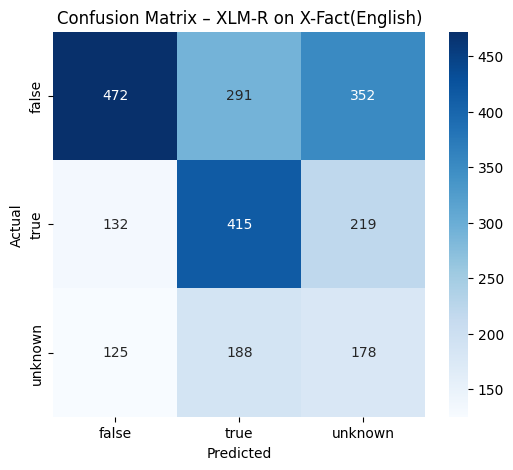

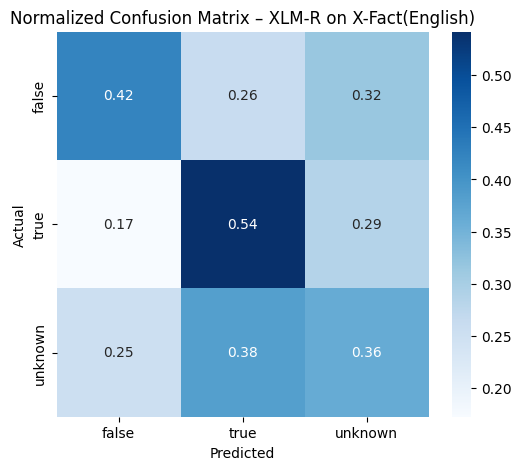

In [ ]:
cm_xmlr = plot_confusion(
    y_true=test_labels_xlmr_en,
    probs=test_probs_xlmr_en,
    title="Confusion Matrix – XLM-R on X-Fact(English)"
)

cm_xmlr_norm = plot_confusion(
    y_true=test_labels_xlmr_en,
    probs=test_probs_xlmr_en,
    normalize=True,
    title="Normalized Confusion Matrix – XLM-R on X-Fact(English)"
)


In [ ]:
errors_xlmr_test_en = make_error_table(
    probs=test_probs_xlmr_en,
    y_true=test_labels_xlmr_en,
    texts=test_en[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_en["language"].tolist(),
    split_name="test",
    model_name="XLM-R"
)

In [ ]:
print("Total misclassified examples on X-fact(English):", len(errors_xlmr_test_en))

Total misclassified examples on X-fact(English): 1307


In [ ]:
XLMR_errors_path_en = os.path.join(output_dir, "x_fact_XLMR_test_en_errors.csv")
errors_xlmr_test_en.to_csv(XLMR_errors_path_en, index=False)

print("Saved XLMR test errors to:", XLMR_errors_path_en)

Saved XLMR test errors to: /content/drive/MyDrive/misinfo_project/x_fact_XLMR_test_en_errors.csv


**Cross-lingual Test on Spanish**

In [ ]:
test_hf_es = HfDataset.from_pandas(test_es[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))

In [ ]:
test_encodings_es = test_hf_es.map(tokenize, batched=True)
test_encodings_es.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
metrics_test_xlmr_es = trainer_eval_with_report(trainer_en, test_encodings_es, "Test (XLM-R) on X-fact(Spanish, EN→ES)")


=== Test (XLM-R) on X-fact(Spanish, EN→ES) ===
Macro-F1     : 0.3207286540619874
Macro AUPRC  : 0.40645884487471456
Micro AUPRC  : 0.43200225901587364
ECE          : 0.15198325738310814

              precision    recall  f1-score   support

       false       0.67      0.16      0.25       116
        true       0.48      0.79      0.60       112
     unknown       0.09      0.14      0.11        28

    accuracy                           0.43       256
   macro avg       0.41      0.36      0.32       256
weighted avg       0.52      0.43      0.39       256



In [ ]:
test_output_es = trainer_en.predict(test_encodings_es)

logits_xlmr_es = test_output_es.predictions
test_labels_xlmr_es = test_output_es.label_ids
test_probs_xlmr_es = torch.softmax(torch.tensor(logits_xlmr_es), dim=-1).cpu().numpy()

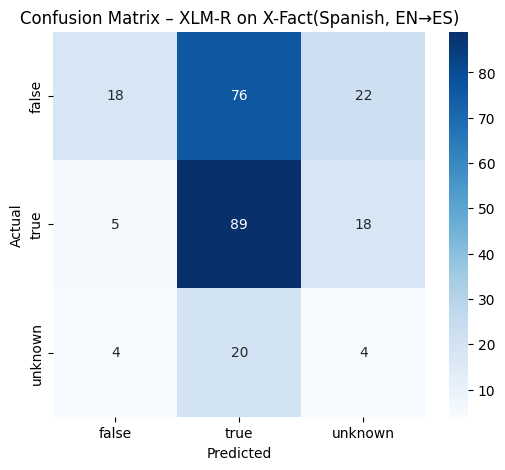

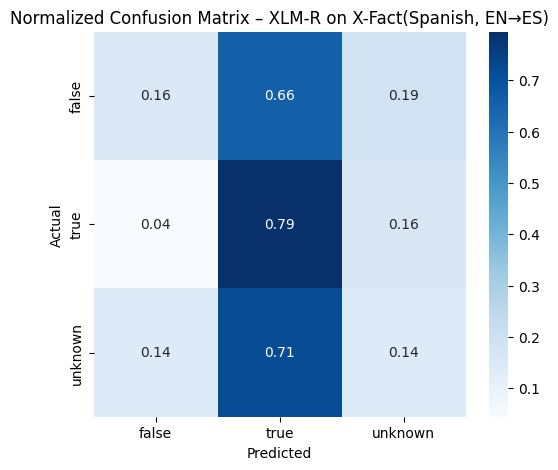

In [ ]:
cm_xmlr_es_cr = plot_confusion(
    y_true=test_labels_xlmr_es,
    probs=test_probs_xlmr_es,
    title="Confusion Matrix – XLM-R on X-Fact(Spanish, EN→ES)"
)

cm_xmlr_es_cr_norm = plot_confusion(
    y_true=test_labels_xlmr_es,
    probs=test_probs_xlmr_es,
    normalize=True,
    title="Normalized Confusion Matrix – XLM-R on X-Fact(Spanish, EN→ES)"
)

In [ ]:
errors_xlmr_test_es_cr = make_error_table(
    probs=test_probs_xlmr_es,
    y_true=test_labels_xlmr_es,
    texts=test_es[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_es["language"].tolist(),
    split_name="test_es_cross",
    model_name="XLM-R (EN→ES)"
)

In [ ]:
print("Total misclassified examples on X-fact(Spanish, EN→ES):", len(errors_xlmr_test_es_cr))

Total misclassified examples on X-fact(Spanish, EN→ES): 145


In [ ]:
XMLR_errors_path_es_cr = os.path.join(output_dir, "x_fact_XLMR_test_es_cr_errors.csv")
errors_xlmr_test_es_cr.to_csv(XMLR_errors_path_es_cr, index=False)

print("Saved XLMR test errors to:", XMLR_errors_path_es_cr)

Saved XLMR test errors to: /content/drive/MyDrive/misinfo_project/x_fact_XLMR_test_es_cr_errors.csv


**Cross-lingual Test on Polish**

In [ ]:
test_hf_pl = HfDataset.from_pandas(test_pl[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))

In [ ]:
test_encodings_pl = test_hf_pl.map(tokenize, batched=True)
test_encodings_pl.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
metrics_test_xlmr_pl = trainer_eval_with_report(trainer_en, test_encodings_pl, "Test (XLM-R) on X-fact(Polish, EN→PL)")


=== Test (XLM-R) on X-fact(Polish, EN→PL) ===
Macro-F1     : 0.2846133260347292
Macro AUPRC  : 0.3307701981017422
Micro AUPRC  : 0.42239522048001626
ECE          : 0.11194767349526964

              precision    recall  f1-score   support

       false       0.34      0.16      0.22       132
        true       0.61      0.59      0.60       229
     unknown       0.02      0.17      0.04        12

    accuracy                           0.42       373
   macro avg       0.32      0.31      0.28       373
weighted avg       0.49      0.42      0.44       373



In [ ]:
test_output_pl = trainer_en.predict(test_encodings_pl)

logits_xlmr_pl = test_output_pl.predictions
test_labels_xlmr_pl = test_output_pl.label_ids
test_probs_xlmr_pl = torch.softmax(torch.tensor(logits_xlmr_pl), dim=-1).cpu().numpy()

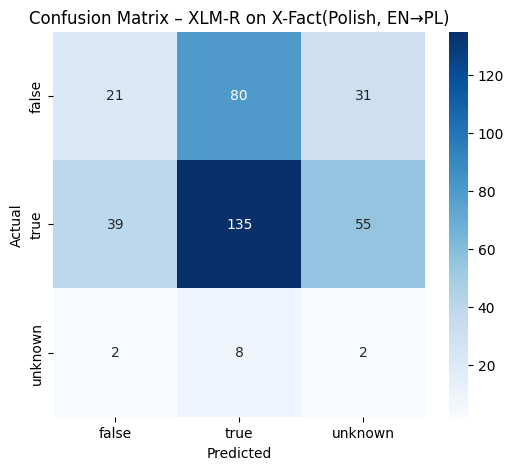

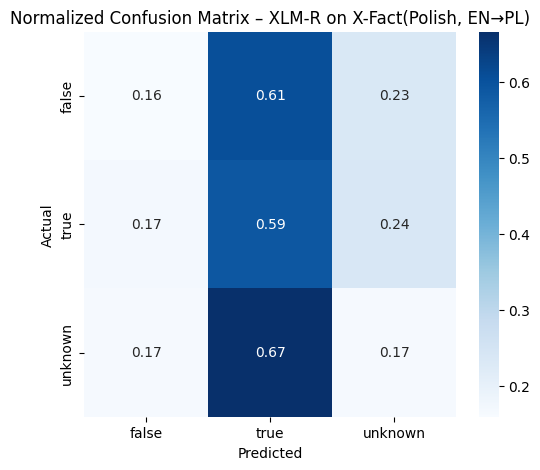

In [ ]:
cm_xmlr_pl_cr = plot_confusion(
    y_true=test_labels_xlmr_pl,
    probs=test_probs_xlmr_pl,
    title="Confusion Matrix – XLM-R on X-Fact(Polish, EN→PL)"
)

cm_xmlr_pl_cr_norm = plot_confusion(
    y_true=test_labels_xlmr_pl,
    probs=test_probs_xlmr_pl,
    normalize=True,
    title="Normalized Confusion Matrix – XLM-R on X-Fact(Polish, EN→PL)"
)

In [ ]:
errors_xlmr_test_pl_cr = make_error_table(
    probs=test_probs_xlmr_pl,
    y_true=test_labels_xlmr_pl,
    texts=test_pl[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_pl["language"].tolist(),
    split_name="test_pl_cross",
    model_name="XLM-R (EN→PL)"
)

In [ ]:
print("Total misclassified examples on X-fact(Polish, EN→PL):", len(errors_xlmr_test_pl_cr))

Total misclassified examples on X-fact(Polish, EN→PL): 215


In [ ]:
XMLR_errors_path_pl_cr = os.path.join(output_dir, "x_fact_XLMR_test_pl_cr_errors.csv")
errors_xlmr_test_pl_cr.to_csv(XMLR_errors_path_pl_cr, index=False)

print("Saved XLMR test errors to:", XMLR_errors_path_pl_cr)

Saved XLMR test errors to: /content/drive/MyDrive/misinfo_project/x_fact_XLMR_test_pl_cr_errors.csv


**Only Spanish: Training and Evaluation**

In [ ]:
train_hf_es = HfDataset.from_pandas(train_es[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))
val_hf_es = HfDataset.from_pandas(val_es[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))
test_hf_es = HfDataset.from_pandas(test_es[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))

In [ ]:
train_encodings_es = train_hf_es.map(tokenize, batched=True)
val_encodings_es = val_hf_es.map(tokenize, batched=True)
test_encodings_es = test_hf_es.map(tokenize, batched=True)

train_encodings_es.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_encodings_es.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_encodings_es.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args_es = TrainingArguments(
    output_dir="/content/drive/MyDrive/misinfo_project/bert_models/x-fact_es_xlmr",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=False,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=30,
    report_to="none",
    save_total_limit=1
)

trainer_es = WeightedTrainer(
    model=model,
    args=training_args_es,
    train_dataset=train_encodings_es,
    eval_dataset=val_encodings_es,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_t_es
)

In [ ]:
trainer_es.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Auprc,Micro Auprc,Ece
1,1.113900,1.096738,0.487603,0.218519,0.348352,0.489697,0.128219
2,1.141100,1.101241,0.487603,0.218519,0.316285,0.448358,0.130124
3,1.108600,1.116227,0.438017,0.273754,0.334234,0.416137,0.112539
4,1.113500,1.134927,0.487603,0.218519,0.317649,0.427947,0.113039
5,1.082000,1.123188,0.388430,0.226653,0.337128,0.419370,0.021876


TrainOutput(global_step=275, training_loss=1.1056948991255326, metrics={'train_runtime': 25.4288, 'train_samples_per_second': 170.673, 'train_steps_per_second': 10.815, 'total_flos': 285478058234880.0, 'train_loss': 1.1056948991255326, 'epoch': 5.0})

In [ ]:
metrics_val_xlmr_es  = trainer_eval_with_report(trainer_es, val_encodings_es,  "Validation (XLM-R) on X-fact(Spanish)")
metrics_test_xlmr_es = trainer_eval_with_report(trainer_es, test_encodings_es, "Test (XLM-R) on X-fact(Spanish)")


=== Validation (XLM-R) on X-fact(Spanish) ===
Macro-F1     : 0.22665312778854732
Macro AUPRC  : 0.3371282143023857
Micro AUPRC  : 0.41937028482375904
ECE          : 0.021876246475976364

              precision    recall  f1-score   support

       false       0.50      0.08      0.14        59
        true       0.38      0.91      0.54        46
     unknown       0.00      0.00      0.00        16

    accuracy                           0.39       121
   macro avg       0.29      0.33      0.23       121
weighted avg       0.39      0.39      0.27       121




=== Test (XLM-R) on X-fact(Spanish) ===
Macro-F1     : 0.29545731336012665
Macro AUPRC  : 0.3560875045885114
Micro AUPRC  : 0.4545081950613336
ECE          : 0.09365146316122264

              precision    recall  f1-score   support

       false       0.53      0.21      0.30       116
        true       0.45      0.85      0.59       112
     unknown       0.00      0.00      0.00        28

    accuracy                           0.46       256
   macro avg       0.33      0.35      0.30       256
weighted avg       0.44      0.46      0.39       256



In [ ]:
test_output_es = trainer_es.predict(test_encodings_es)

logits_xlmr_es = test_output_es.predictions
test_labels_xlmr_es = test_output_es.label_ids
test_probs_xlmr_es = torch.softmax(torch.tensor(logits_xlmr_es), dim=-1).cpu().numpy()

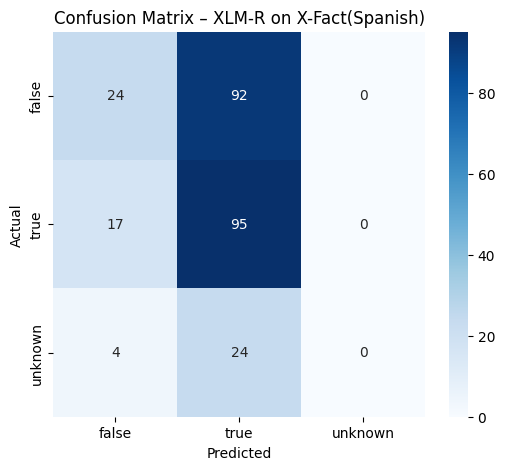

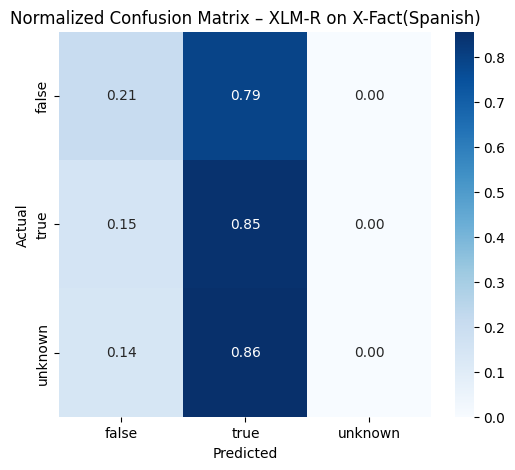

In [ ]:
cm_xmlr_es = plot_confusion(
    y_true=test_labels_xlmr_es,
    probs=test_probs_xlmr_es,
    title="Confusion Matrix – XLM-R on X-Fact(Spanish)"
)

cm_xml_es_norm = plot_confusion(
    y_true=test_labels_xlmr_es,
    probs=test_probs_xlmr_es,
    normalize=True,
    title="Normalized Confusion Matrix – XLM-R on X-Fact(Spanish)"
)

In [ ]:
errors_xlmr_test_es = make_error_table(
    probs=test_probs_xlmr_es,
    y_true=test_labels_xlmr_es,
    texts=test_es[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_es["language"].tolist(),
    split_name="test_es",
    model_name="XLM-R(ES)"
)

In [ ]:
XLMR_errors_path_es = os.path.join(output_dir, "x_fact_XLMR_test_es_errors.csv")
errors_xlmr_test_es.to_csv(XLMR_errors_path_es, index=False)

print("Saved XLMR test errors to:", XLMR_errors_path_es)

Saved XLMR test errors to: /content/drive/MyDrive/misinfo_project/x_fact_XLMR_test_es_errors.csv


**Only Polish: Training and Evaluation**

In [ ]:
train_hf_pl = HfDataset.from_pandas(train_pl[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))
val_hf_pl = HfDataset.from_pandas(val_pl[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))
test_hf_pl = HfDataset.from_pandas(test_pl[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))

In [ ]:
print(train_hf_pl[10])

{'text': '(…) przecież nie będzie żadnej stacji przeładunkowej odpadów. takie zapewnienia składała gwiazda łódzkiego magistratu – pan wiceprezydent tomasz trela. teraz widzimy jak rusza budowa hali tej stacji.', 'labels': 1}


In [ ]:
train_encodings_pl = train_hf_pl.map(tokenize, batched=True)
val_encodings_pl = val_hf_pl.map(tokenize, batched=True)
test_encodings_pl = test_hf_pl.map(tokenize, batched=True)

train_encodings_pl.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_encodings_pl.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_encodings_pl.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args_pl = TrainingArguments(
    output_dir="/content/drive/MyDrive/misinfo_project/bert_models/x-fact_pl_xlmr",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=False,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    save_total_limit=1
)

trainer_pl = WeightedTrainer(
    model=model,
    args=training_args_pl,
    train_dataset=train_encodings_pl,
    eval_dataset=val_encodings_pl,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_t_pl
)

In [ ]:
trainer_pl.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Auprc,Micro Auprc,Ece
1,1.112400,1.047813,0.543353,0.234707,0.376036,0.535327,0.140217
2,1.111900,1.027327,0.537572,0.241095,0.375861,0.538153,0.126949
3,1.077400,1.017733,0.543353,0.359330,0.376126,0.531368,0.086034
4,1.045700,1.090413,0.468208,0.333281,0.391371,0.510581,0.078333
5,0.941800,1.113231,0.491329,0.342114,0.399878,0.538498,0.075845


TrainOutput(global_step=380, training_loss=1.0397892098677786, metrics={'train_runtime': 35.5283, 'train_samples_per_second': 171.131, 'train_steps_per_second': 10.696, 'total_flos': 399932394946560.0, 'train_loss': 1.0397892098677786, 'epoch': 5.0})

In [ ]:
metrics_val_xlmr_pl  = trainer_eval_with_report(trainer_pl, val_encodings_pl,  "Validation (XLM-R) on X-fact(Polish)")
metrics_test_xlmr_pl = trainer_eval_with_report(trainer_pl, test_encodings_pl, "Test (XLM-R) on X-fact(Polish)")


=== Validation (XLM-R) on X-fact(Polish) ===
Macro-F1     : 0.3421141888072357
Macro AUPRC  : 0.39987825497708124
Micro AUPRC  : 0.5384983020405759
ECE          : 0.07584482086876222

              precision    recall  f1-score   support

       false       0.47      0.47      0.47        73
        true       0.57      0.54      0.56        94
     unknown       0.00      0.00      0.00         6

    accuracy                           0.49       173
   macro avg       0.35      0.34      0.34       173
weighted avg       0.51      0.49      0.50       173




=== Test (XLM-R) on X-fact(Polish) ===
Macro-F1     : 0.3513100176497701
Macro AUPRC  : 0.3501372772674267
Micro AUPRC  : 0.4578222521259996
ECE          : 0.08244907384583522

              precision    recall  f1-score   support

       false       0.39      0.49      0.44       132
        true       0.63      0.47      0.54       229
     unknown       0.05      0.17      0.08        12

    accuracy                           0.47       373
   macro avg       0.36      0.38      0.35       373
weighted avg       0.53      0.47      0.49       373



In [ ]:
test_output_pl = trainer_pl.predict(test_encodings_pl)

logits_xlmr_pl = test_output_pl.predictions
test_labels_xlmr_pl = test_output_pl.label_ids
test_probs_xlmr_pl = torch.softmax(torch.tensor(logits_xlmr_pl), dim=-1).cpu().numpy()

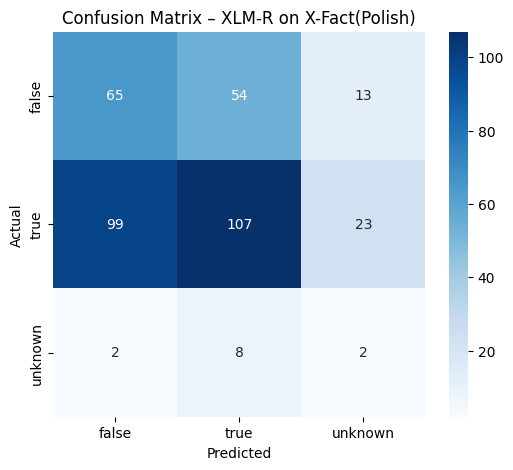

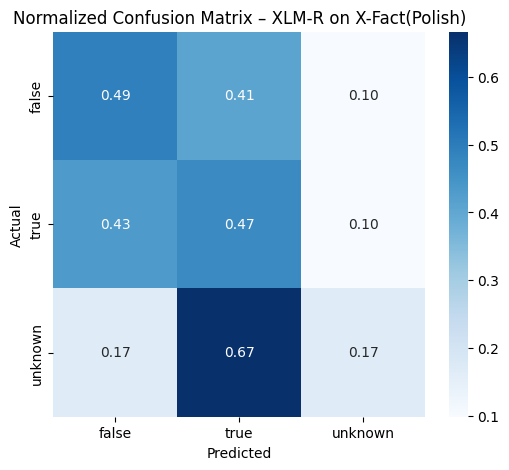

In [ ]:
cm_xmlr_pl = plot_confusion(
    y_true=test_labels_xlmr_pl,
    probs=test_probs_xlmr_pl,
    title="Confusion Matrix – XLM-R on X-Fact(Polish)"
)

cm_xmlr_pl_norm = plot_confusion(
    y_true=test_labels_xlmr_pl,
    probs=test_probs_xlmr_pl,
    normalize=True,
    title="Normalized Confusion Matrix – XLM-R on X-Fact(Polish)"
)

In [ ]:
errors_xlmr_test_pl = make_error_table(
    probs=test_probs_xlmr_pl,
    y_true=test_labels_xlmr_pl,
    texts=test_pl[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_pl["language"].tolist(),
    split_name="test_pl",
    model_name="XLM-R(PL)"
)

In [ ]:
XLMR_errors_path_pl = os.path.join(output_dir, "x_fact_XLMR_test_pl_errors.csv")
errors_xlmr_test_pl.to_csv(XLMR_errors_path_pl, index=False)

print("Saved XLMR test errors to:", XLMR_errors_path_pl)

Saved XLMR test errors to: /content/drive/MyDrive/misinfo_project/x_fact_XLMR_test_pl_errors.csv


## **Error Analysis Across Models**

To complement aggregate metrics, qualitative error analysis is conducted for all models.

* For each model (TF–IDF+NB, FastText+MLP, and XLM-R), the saved **test-set error tables** are loaded.
* The frequency of each misclassification pair `(actual_label → predicted_label)` is summarized.
* High-confidence errors—cases where the predicted probability is high but the prediction is incorrect—are inspected.
* Representative examples are examined for the most common confusion patterns (e.g., `unknown → true`, `true → false`).

This analysis helps identify:

* whether certain labels are systematically confused,
* whether high-confidence mistakes involve patterns such as **negation**, **subtle phrasing**, or **world-knowledge requirements**,
* and whether XLM-R reduces specific error types relative to the lexical or shallow neural baselines.




In [ ]:
def summarize_errors(df):
    print("\n=== Error Counts by (actual → pred) ===")
    print(df.groupby(["actual", "pred"]).size())

    if "language" in df.columns:
        print("\n=== Errors by language (counts) ===")
        lang_counts = df["language"].value_counts()
        print(lang_counts)

        print("\n=== Errors by language (percentage) ===")
        print((lang_counts / len(df) * 100).round(2).astype(str) + "%")

    print("\n=== Top 10 high-confidence wrong predictions ===")
    print(
        df.sort_values("conf", ascending=False)
          .head(10)[["idx", "text", "actual", "pred", "conf", "language"]]
    )

In [ ]:
def inspect_top_error_pairs(df, top_n=3, k=5):
    pair_counts = (
        df.groupby(["actual", "pred"]).size()
          .sort_values(ascending=False)
          .head(top_n)
    )

    print("\nTop error pairs:")
    print(pair_counts)

    for (actual, pred), _ in pair_counts.items():
        show_errors(df, actual_label=actual, pred_label=pred, k=k)


In [ ]:
errors_nb_test_en = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_en_nb_test_errors.csv")
errors_nb_test_es_cr = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_es_cr_nb_test_errors.csv")
errors_nb_test_es_mono = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_es_mono_nb_test_errors.csv")
errors_nb_test_pl = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_pl_nb_test_errors.csv")
erros_FT_MLP_test_en = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_en_FT_MLP_test_errors.csv")
errors_FT_MLP_test_es_cr = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_es_cr_FT_MLP_test_errors.csv")
errors_FT_MLP_test_es = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_es_FT_MLP_test_errors.csv")
errors_FT_MLP_test_pl = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_pl_FT_MLP_test_errors.csv")
errors_xlmr_test_en = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_XLMR_test_en_errors.csv")
errors_xlmr_test_es_cr = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_XLMR_test_es_cr_errors.csv")
errors_xlmr_test_pl_cr = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_XLMR_test_pl_cr_errors.csv")
errors_xlmr_test_es = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_XLMR_test_es_errors.csv")
errors_xlmr_test_pl = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_XLMR_test_pl_errors.csv")

In [ ]:
summarize_errors(errors_nb_test_en)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       278
         unknown     65
true     false      324
         unknown     46
unknown  false      259
         true       197
dtype: int64

=== Errors by language (counts) ===
language
en    1169
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
en    100.0%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
       idx                                               text   actual   pred  \
304    628  "rhode island has the highest percentage of la...    false   true   
628   1294  health care reform "requires the use of federa...  unknown  false   
978   1988  says ted cruz "wanted to let in more syrian re...  unknown  false   
569   1172     barack obama was "a trial attorney for acorn."  unknown  false   
643   1318  if it is enacted, the senate immigration bill ...     true  false   
1136  2318  women "earn only 77 cents for every dollar ear...    false   tru

In [ ]:
inspect_top_error_pairs(errors_nb_test_en, top_n=3, k=5)


Top error pairs:
actual   pred 
true     false    324
false    true     278
unknown  false    259
dtype: int64

=== 324 examples where actual=true, pred=false ===

[idx=1318] conf=0.676
LANG: en
TEXT: if it is enacted, the senate immigration bill is "going to make the border patrol bigger than the fbi -- you could put one agent every 250 feet."
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=1877] conf=0.633
LANG: en
TEXT: says president barack obama "will not utter the words ‘radical islamic terrorism’ and as matter of policy, nobody in the administration will say the words ‘radical islamic terrorism.’"
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=1627] conf=0.629
LANG: en
TEXT: says barack obama "is the first president in modern history not to have a single year of 3 percent growth."
ACTUAL: true | PRED: false
------------------------------------------

In [ ]:
summarize_errors(errors_nb_test_es_cr)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       10
         unknown    11
true     false      91
         unknown    18
unknown  false      24
         true        1
dtype: int64

=== Errors by language (counts) ===
language
es    155
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
es    100.0%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
     idx                                               text   actual   pred  \
151  252       “un millón de jóvenes no estudia ni trabaja”     true  false   
136  230  “todas aquellas que reciben una asignación bus...  unknown  false   
6      8  "en la argentina muere más gente producto de u...     true  false   
39    66  “bajamos impuestos por 1,6 puntos del pbi, una...     true  false   
118  197  “lo que más viene creciendo en términos de exp...     true  false   
150  250  “un alimento tiene 40% de impuestos entre naci...     true  false   
96   159  “la mi

In [ ]:
inspect_top_error_pairs(errors_nb_test_es_cr, top_n=3, k=5)


Top error pairs:
actual   pred   
true     false      91
unknown  false      24
true     unknown    18
dtype: int64

=== 91 examples where actual=true, pred=false ===

[idx=252] conf=0.534
LANG: es
TEXT: “un millón de jóvenes no estudia ni trabaja”
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=8] conf=0.505
LANG: es
TEXT: "en la argentina muere más gente producto de un accidente de tránsito que a raíz de un hecho delictivo"
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=66] conf=0.499
LANG: es
TEXT: “bajamos impuestos por 1,6 puntos del pbi, una de las bajas más importantes que se haya hecho”
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=197] conf=0.493
LANG: es
TEXT: “lo que más viene creciendo en términos de exportación son las manufacturas de origen industrial”
ACTUAL: true | PRED: fal

In [ ]:
summarize_errors(errors_nb_test_es_mono)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       53
         unknown     6
true     false      50
         unknown     5
unknown  false      11
         true       14
dtype: int64

=== Errors by language (counts) ===
language
es    139
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
es    100.0%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
     idx                                               text   actual   pred  \
114  206  “no hubo ninguna sesión ordinaria, y tuvimos t...     true  false   
75   143  “ha aumentado en los últimos años la cantidad ...    false   true   
135  243  “washington d.c. tiene más tasa de mortalidad ...    false   true   
65   128  “en un país normal los trabajadores no pagan i...    false   true   
128  231  “todas las ciudades grandes del mundo tienen u...     true  false   
130  234  “tres de cada diez productos se venden en los ...    false   true   
5      6  "en el

In [ ]:
inspect_top_error_pairs(errors_nb_test_es_mono, top_n=3, k=5)


Top error pairs:
actual   pred 
false    true     53
true     false    50
unknown  true     14
dtype: int64

=== 53 examples where actual=false, pred=true ===

[idx=143] conf=0.582
LANG: es
TEXT: “ha aumentado en los últimos años la cantidad de jóvenes que ni estudian ni trabajan”
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=243] conf=0.572
LANG: es
TEXT: “washington d.c. tiene más tasa de mortalidad infantil que la argentina”
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=128] conf=0.560
LANG: es
TEXT: “en un país normal los trabajadores no pagan impuesto a las ganancias”
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=234] conf=0.520
LANG: es
TEXT: “tres de cada diez productos se venden en los supermercados”
ACTUAL: false | PRED: true
-----------------------------------------------------

In [ ]:
summarize_errors(errors_nb_test_pl)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       87
         unknown     2
true     false      72
         unknown     4
unknown  false       5
         true        6
dtype: int64

=== Errors by language (counts) ===
language
pl    176
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
pl    100.0%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
     idx                                               text actual   pred  \
28    72  europejski bank centralny dla strefy euro druk...  false   true   
157  332  według danych głównego urzędu statystycznego k...  false   true   
61   146  mrożone są wydatki na polską akademię nauk, kt...   true  false   
96   214  polska gospodarka jest dziś bardzo nisko innow...  false   true   
93   210  poznań zajmuje niechlubne pierwsze miejsce, je...  false   true   
85   196  po pierwsze ani jeden postulat organizatorów p...  false   true   
136  291  w ciągu ostatnich 5 

In [ ]:
inspect_top_error_pairs(errors_nb_test_pl, top_n=3, k=5)


Top error pairs:
actual   pred 
false    true     87
true     false    72
unknown  true      6
dtype: int64

=== 87 examples where actual=false, pred=true ===

[idx=72] conf=0.555
LANG: pl
TEXT: europejski bank centralny dla strefy euro drukuje pieniądze, a więc dokapitalizowuje cały czas tą strefę i to w ilości 1 biliona 400 miliardów rocznie, to są gigantyczne pieniądze, które przewyższają kilkukrotnie budżet niemiec.
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=332] conf=0.554
LANG: pl
TEXT: według danych głównego urzędu statystycznego kraków jest na szarym końcu rankingów na zielone miasta polski. według statystyk tereny zielone ogółem zajmują w krakowie 9 proc. powierzchni miasta!
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=214] conf=0.546
LANG: pl
TEXT: polska gospodarka jest dziś bardzo nisko innowacyjna. my jesteśmy na jednych z ostatnich mie

In [ ]:
summarize_errors(erros_FT_MLP_test_en)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       331
         unknown    285
true     false      159
         unknown    228
unknown  false      127
         true       188
dtype: int64

=== Errors by language (counts) ===
language
en    1318
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
en    100.0%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
       idx                                               text   actual   pred  \
779   1392  38. garantir que o iss recolhido pela uber sob...  unknown  false   
653   1172  "you can import as many hemp products into thi...  unknown  false   
648   1161  "we’re making (medicare) stronger. we’re makin...     true  false   
1026  1842  até quando mendigo vai ficar sem pagar iptu? #...     true  false   
518    944  "the white house promised us that all the spen...     true  false   
70     133  "as governor of florida i defunded planned par...  unknown  fals

In [ ]:
inspect_top_error_pairs(erros_FT_MLP_test_en, top_n=3, k=5)


Top error pairs:
actual  pred   
false   true       331
        unknown    285
true    unknown    228
dtype: int64

=== 331 examples where actual=false, pred=true ===

[idx=628] conf=0.745
LANG: en
TEXT: "officials at hyperloop one have referred to the route as one of the best they've ever seen."
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=630] conf=0.683
LANG: en
TEXT: "ohio is doing better right now than the national average on all the (economic) numbers."
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=2317] conf=0.682
LANG: en
TEXT: em apenas oito meses, concluímos (..) [os acordos de livre comércio]: mercosul e união europeia, mercosul e efta [associação europeia de livre comércio]
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=469] conf=0.675
LANG: en
TEXT: "it was under barack obam

In [ ]:
summarize_errors(errors_FT_MLP_test_es_cr)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true        7
         unknown    10
true     false      94
         unknown     7
unknown  false      26
         true        2
dtype: int64

=== Errors by language (counts) ===
language
es    146
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
es    100.0%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
     idx                                               text   actual   pred  \
72   126  “en todo el mundo están abandonando el voto el...     true  false   
30    56  “con el sistema actual, los procesos duran un ...  unknown  false   
52    93  “el presupuesto educativo desde el 2015 a hoy ...     true  false   
120  215          “pasó en 2016 que el consumo cayó un 10%”     true  false   
6     10  "en lo que va del año cerraron 43 empresas por...  unknown  false   
59   105    “el año pasado contrajimos más deuda que china”     true  false   
0      0  "[en e

In [ ]:
inspect_top_error_pairs(errors_FT_MLP_test_es_cr, top_n=3, k=5)


Top error pairs:
actual   pred   
true     false      94
unknown  false      26
false    unknown    10
dtype: int64

=== 94 examples where actual=true, pred=false ===

[idx=126] conf=0.847
LANG: es
TEXT: “en todo el mundo están abandonando el voto electrónico”
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=93] conf=0.826
LANG: es
TEXT: “el presupuesto educativo desde el 2015 a hoy cayó un 40%”
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=215] conf=0.826
LANG: es
TEXT: “pasó en 2016 que el consumo cayó un 10%”
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=105] conf=0.815
LANG: es
TEXT: “el año pasado contrajimos más deuda que china”
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=0] conf=0.814
LANG: es
TEXT: "[en educación] 

In [ ]:
summarize_errors(errors_FT_MLP_test_es)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       34
         unknown    48
true     false      34
         unknown    43
unknown  false      11
         true       11
dtype: int64

=== Errors by language (counts) ===
language
es    181
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
es    100.0%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
     idx                                               text actual     pred  \
11    13   "mejoramos la infraestructura de 19 aeropuertos"   true  unknown   
151  214                    “mejoramos la situación fiscal”  false  unknown   
113  161  “la participación nacional de celulares pasó a...  false  unknown   
114  162        “la producción de ypf va cayendo mes a mes”  false  unknown   
12    14  "mientras pagábamos esas tarifas, la producció...  false  unknown   
107  150    “hay una tendencia a la baja [de la inflación]”  false  unknown   
109  152  “hemos

In [ ]:
inspect_top_error_pairs(errors_FT_MLP_test_es, top_n=3, k=5)


Top error pairs:
actual  pred   
false   unknown    48
true    unknown    43
false   true       34
dtype: int64

=== 48 examples where actual=false, pred=unknown ===

[idx=214] conf=0.424
LANG: es
TEXT: “mejoramos la situación fiscal”
ACTUAL: false | PRED: unknown
--------------------------------------------------------------------------------
[idx=161] conf=0.417
LANG: es
TEXT: “la participación nacional de celulares pasó al 97%”
ACTUAL: false | PRED: unknown
--------------------------------------------------------------------------------
[idx=162] conf=0.411
LANG: es
TEXT: “la producción de ypf va cayendo mes a mes”
ACTUAL: false | PRED: unknown
--------------------------------------------------------------------------------
[idx=14] conf=0.404
LANG: es
TEXT: "mientras pagábamos esas tarifas, la producción de gas declinaba"
ACTUAL: false | PRED: unknown
--------------------------------------------------------------------------------
[idx=150] conf=0.403
LANG: es
TEXT: “hay una tende

In [ ]:
summarize_errors(errors_FT_MLP_test_pl)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       39
         unknown    48
true     false      72
         unknown    67
unknown  false       5
         true        4
dtype: int64

=== Errors by language (counts) ===
language
pl    235
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
pl    100.0%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
     idx                                               text actual     pred  \
226  359  za hitlera był zakaz aborcji, za stalina był z...  false  unknown   
135  216              polska jest szóstą gospodarką europy.  false  unknown   
131  207  powołałem swojego przedstawiciela do komisji d...   true  unknown   
67   101  jastrzębie-zdrój, 90-tysięczne miasto (...) zo...   true  unknown   
134  212  posterunki straży granicznej były likwidowane ...   true  unknown   
62    96  jestem 7 kandydatem, ale jedynym, który przeds...  false  unknown   
60    93  jest o

In [ ]:
inspect_top_error_pairs(errors_FT_MLP_test_pl, top_n=3, k=5)


Top error pairs:
actual  pred   
true    false      72
        unknown    67
false   unknown    48
dtype: int64

=== 72 examples where actual=true, pred=false ===

[idx=237] conf=0.474
LANG: pl
TEXT: reforma wprowadza kontradyktoryjność tylko i wyłącznie do etapu sądowego postępowania karnego
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=103] conf=0.462
LANG: pl
TEXT: ja wygrałem wybory parlamentarne jako jedyny spośród kandydatów zjednoczonej lewicy, wygrałem ze wszystkimi i to w trudnym okręgu okręgu toruńskim i pokonałem wszystkich z pisu i po.
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=350] conf=0.461
LANG: pl
TEXT: złożyliśmy wniosek o dofinansowanie mostu na wyspę sobieszewską, rząd pani szydło to podtrzymał i dostaliśmy 50 procent dofinansowania.
ACTUAL: true | PRED: false
-----------------------------------------------------------------------

In [ ]:
summarize_errors(errors_xlmr_test_en)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       291
         unknown    352
true     false      132
         unknown    219
unknown  false      125
         true       188
dtype: int64

=== Errors by language (counts) ===
language
en    1307
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
en    100.0%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
       idx                                               text   actual   pred  \
826   1533  says "catherine cortez masto indicted (brian k...  unknown  false   
755   1401  measures taken by my administration "have save...     true  false   
501    944  "u.s. taxpayers are being forced to fund feisa...     true  false   
1029  1890  says opponent beto o’rourke "wants to legalize...  unknown  false   
23      52  "amendment 2 will bring kid-friendly pot candy...  unknown  false   
1292  2340                  zika mosquitoes "can’t catch me."     true  fals

In [ ]:
inspect_top_error_pairs(errors_xlmr_test_en, top_n=3, k=5)


Top error pairs:
actual  pred   
false   unknown    352
        true       291
true    unknown    219
dtype: int64

=== 352 examples where actual=false, pred=unknown ===

[idx=1236] conf=0.732
LANG: en
TEXT: dewine "took $1.9 million from big banks," "supported legislation that helped bernie madoff make millions" and "protected predatory lenders while families lost their homes."
ACTUAL: false | PRED: unknown
--------------------------------------------------------------------------------
[idx=1225] conf=0.719
LANG: en
TEXT: democrats plan to keep student loan interest rates low "by raising taxes on small businesses, very small businesses … the kinds of small businesses that give jobs to graduates."
ACTUAL: false | PRED: unknown
--------------------------------------------------------------------------------
[idx=1564] conf=0.706
LANG: en
TEXT: says "our economy in new jersey gets $38 billion from the businesses at the shore."
ACTUAL: false | PRED: unknown
-----------------------------

In [ ]:
summarize_errors(errors_xlmr_test_es_cr)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       76
         unknown    22
true     false       5
         unknown    18
unknown  false       4
         true       20
dtype: int64

=== Errors by language (counts) ===
language
es    145
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
es    100.0%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
     idx                                               text   actual   pred  \
17    23  obama no viene porque la argentina no quiere c...  unknown  false   
97   166  “la educación pública perdió chicos en las esc...     true  false   
63   107  “el conurbano tiene intendentes que gobiernan ...    false   true   
6     10  "en lo que va del año cerraron 43 empresas por...  unknown   true   
139  241  “somos el segundo país con mayor circulación d...  unknown   true   
93   160     “la mínima [de un jubilado] son $9 mil y pico”    false   true   
91   157  “la ma

In [ ]:
inspect_top_error_pairs(errors_xlmr_test_es_cr, top_n=3, k=5)


Top error pairs:
actual   pred   
false    true       76
         unknown    22
unknown  true       20
dtype: int64

=== 76 examples where actual=false, pred=true ===

[idx=107] conf=0.745
LANG: es
TEXT: “el conurbano tiene intendentes que gobiernan sus distritos hace 15 años en promedio”
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=160] conf=0.725
LANG: es
TEXT: “la mínima [de un jubilado] son $9 mil y pico”
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=157] conf=0.725
LANG: es
TEXT: “la mayor inversión en la historia, en términos de metros construidos”
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=142] conf=0.724
LANG: es
TEXT: “hay una penetración de internet de banda ancha del 2%, cuando el promedio de la región es el 20%”
ACTUAL: false | PRED: true
---------------------------------

In [ ]:
summarize_errors(errors_xlmr_test_pl_cr)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       80
         unknown    31
true     false      39
         unknown    55
unknown  false       2
         true        8
dtype: int64

=== Errors by language (counts) ===
language
pl    215
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
pl    100.0%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
     idx                                               text   actual   pred  \
157  274  u pielęgniarek jest sytuacja też tragiczna - ś...     true  false   
110  191  pan ziobro jeździł do strasburga, mówił o pols...     true  false   
170  292  w ciągu ostatnich kilkunastu lat centrum miast...     true  false   
54    94  jest program rządowy, który rozwija idee z ust...     true  false   
17    32  bezrobocie jest o połowę niższe niż było w 201...    false   true   
146  252            szkół wyższych w polsce jest około 130.    false   true   
87   153  na kon

In [ ]:
inspect_top_error_pairs(errors_xlmr_test_pl_cr, top_n=3, k=5)


Top error pairs:
actual  pred   
false   true       80
true    unknown    55
        false      39
dtype: int64

=== 80 examples where actual=false, pred=true ===

[idx=32] conf=0.757
LANG: pl
TEXT: bezrobocie jest o połowę niższe niż było w 2015 roku.
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=252] conf=0.753
LANG: pl
TEXT: szkół wyższych w polsce jest około 130.
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=198] conf=0.735
LANG: pl
TEXT: po trzydziestu latach funkcjonowania dwie trzecie ludzi nie uzbierało na najniższą emeryturę.
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=245] conf=0.732
LANG: pl
TEXT: seniorzy to jest w tej chwili ponad 40% ludności gdańska.
ACTUAL: false | PRED: true
--------------------------------------------------------------------------------
[idx=283] conf

In [ ]:
summarize_errors(errors_xlmr_test_es)


=== Error Counts by (actual → pred) ===
actual   pred 
false    True     92
true     False    17
unknown  False     4
         True     24
dtype: int64

=== Errors by language (counts) ===
language
es    137
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
es    100.0%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
     idx                                               text   actual   pred  \
20    30  “[se robó] diez mil millones de euros, sólo el...  unknown   True   
18    28  “[la provincia de buenos aires] aumentó su deu...    false   True   
30    51  “[tienen] un costo promedio 40% más barato que...    false   True   
24    36      “[entre 2003 y 2011] creamos 300 mil empleos”    false   True   
19    29  “[no hay] un gobierno que haya avanzado como n...    false   True   
0      1  "[la importación de energía] no representa más...    false   True   
110  196  “le vendemos us$ 4.000 millones en total [a lo...    false   T

In [ ]:
inspect_top_error_pairs(errors_xlmr_test_es, top_n=3, k=5)


Top error pairs:
actual   pred 
false    True     92
unknown  True     24
true     False    17
dtype: int64

=== 92 examples where actual=false, pred=True ===

[idx=28] conf=0.421
LANG: es
TEXT: “[la provincia de buenos aires] aumentó su deuda provincial en un 113%”
ACTUAL: false | PRED: True
--------------------------------------------------------------------------------
[idx=51] conf=0.419
LANG: es
TEXT: “[tienen] un costo promedio 40% más barato que en el 2015 y este ahorro nos permite hacer más obras”
ACTUAL: false | PRED: True
--------------------------------------------------------------------------------
[idx=36] conf=0.414
LANG: es
TEXT: “[entre 2003 y 2011] creamos 300 mil empleos”
ACTUAL: false | PRED: True
--------------------------------------------------------------------------------
[idx=29] conf=0.412
LANG: es
TEXT: “[no hay] un gobierno que haya avanzado como nosotros en el cumplimiento de la ley de basura cero”
ACTUAL: false | PRED: True
------------------------------

In [ ]:
summarize_errors(errors_xlmr_test_pl)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       54
         unknown    13
true     false      99
         unknown    23
unknown  false       2
         true        8
dtype: int64

=== Errors by language (counts) ===
language
pl    199
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
pl    100.0%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
     idx                                               text actual     pred  \
179  331  we wrocławiu na 1000 mieszkańców przypada aż 6...   true  unknown   
35    58  dzisiaj różnica wydatków na administrację publ...  false     true   
10    15  59% polaków opowiada się przeciwko przyjmowani...   true  unknown   
41    65  dzisiaj liczba zakażeń w polsce jest większa n...   true  unknown   
167  305  w roku 2018 wskaźnik zagrożenia ubóstwem lub w...  false     true   
191  356  z ukrainy jest u nas około pół miliona uchodźców.  false  unknown   
137  249  spółki

In [ ]:
inspect_top_error_pairs(errors_xlmr_test_pl, top_n=3, k=5)


Top error pairs:
actual  pred   
true    false      99
false   true       54
true    unknown    23
dtype: int64

=== 99 examples where actual=true, pred=false ===

[idx=191] conf=0.700
LANG: pl
TEXT: pan ziobro jeździł do strasburga, mówił o polsce, że jest łamana demokracja, to samo, podobnie mówił macierewicz swego czasu.
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=266] conf=0.682
LANG: pl
TEXT: to premier morawiecki ogłosił (przed wyborami przyp.), że covidu już nie ma.
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=33] conf=0.654
LANG: pl
TEXT: białoruś jest krajem, w którym wciąż w więzieniu znajduje się jeden z kandydatów w wyborach prezydenckich sprzed pięciu lat, mikoła statkiewicz
ACTUAL: true | PRED: false
--------------------------------------------------------------------------------
[idx=165] conf=0.647
LANG: pl
TEXT: nie udało się powtórz